# GLM: Click Inputs to Decision Variables with sklearn ElasticNetCV

Build a GLM to predict decision variables DV(t) from click input data for the first 240 trials of session A324_2023-07-27, using Gaussian basis functions and ElasticNet regularization (L1 ratio = 0.95).

In [1083]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# GLM libraries - using sklearn ElasticNetCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Set random seed for reproducibility
np.random.seed(42)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Built-in standardization enabled (no sklearn StandardScaler needed)")

Built-in standardization enabled (no sklearn StandardScaler needed)


## 1. Data Loading and Preparation

Load session data and filter to first 240 trials.

In [1084]:
# Data paths configuration
PROJECT_ROOT = Path('/home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV')
SESSION_ID = 'A324'
SESSION_DATE = '2023-07-27'  # Using the date from the plan

# Path to processed H5 file (this is what we'll actually use)
OUTPUT_DIR = PROJECT_ROOT / 'data' / 'processed' / SESSION_ID / SESSION_DATE
H5_FILE = OUTPUT_DIR / f'{SESSION_ID}_{SESSION_DATE}_session_data.h5'

# Verify H5 file exists
if not H5_FILE.exists():
    raise FileNotFoundError(f"Processed H5 file not found: {H5_FILE}")

print(f"Project root: {PROJECT_ROOT}")
print(f"Session: {SESSION_ID} ({SESSION_DATE})")
print(f"H5 file: {H5_FILE}")
print(f"H5 file size: {H5_FILE.stat().st_size / 1024 / 1024:.1f} MB")

Project root: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV
Session: A324 (2023-07-27)
H5 file: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
H5 file size: 154.2 MB


In [1085]:
def load_session_data(h5_file_path=None):
    """
    Load session data from H5 file and return DataFrames
    
    Args:
        h5_file_path: Path to H5 file (uses global H5_FILE if None)
    
    Returns:
        trial_df: Trial metadata
        click_df: Click events data  
        dv_df: Decision variables data
    """
    if h5_file_path is None:
        h5_file_path = H5_FILE
    
    if not h5_file_path.exists():
        raise FileNotFoundError(f"Data file not found: {h5_file_path}")
    
    print(f"Loading data from: {h5_file_path}")
    
    # Use pandas HDFStore to load the data
    with pd.HDFStore(h5_file_path, mode='r') as store:
        trial_df = store.get('trials')
        click_df = store.get('clicks')
        dv_df = store.get('decision_variables')
    
    print(f"Loaded {len(trial_df)} trials, {len(click_df)} clicks, {len(dv_df)} DV points")
    
    return trial_df, click_df, dv_df

In [1086]:
# Load full session data
trial_df, click_df, dv_df = load_session_data()

min_session_trials = 900

# Filter to first 900 trials
trial_df_240 = trial_df[trial_df['trial_id'] < min_session_trials].copy()
click_df_240 = click_df[click_df['trial_id'] < min_session_trials].copy()
dv_df_240 = dv_df[dv_df['trial_id'] < min_session_trials].copy()

print(f"\nFiltered to first {min_session_trials} trials:")
print(f"Trials: {len(trial_df_240)}")
print(f"Clicks: {len(click_df_240)}")
print(f"DV points: {len(dv_df_240)}")
print(f"Valid DV points: {dv_df_240['is_valid'].sum()}")

Loading data from: /home/ham/SF/Personal/Education/07 Princeton/Rotations/Brody-Daw/ClickDV/data/processed/A324/2023-07-27/A324_2023-07-27_session_data.h5
Loaded 774 trials, 22144 clicks, 17028 DV points

Filtered to first 900 trials:
Trials: 774
Clicks: 22144
DV points: 17028
Valid DV points: 13860


In [1087]:
# Data validation and exploration
print("Click distribution:")
print(click_df_240['click_side'].value_counts())

print("\nDV statistics:")
valid_dvs = dv_df_240[dv_df_240['is_valid']]
print(f"DV range: [{valid_dvs['decision_variable'].min():.3f}, {valid_dvs['decision_variable'].max():.3f}]")
print(f"DV mean: {valid_dvs['decision_variable'].mean():.3f}")
print(f"DV std: {valid_dvs['decision_variable'].std():.3f}")

print("\nTrial duration statistics:")
trial_durations = trial_df_240.groupby('trial_id')['trial_duration'].first()
print(f"Duration range: [{trial_durations.min():.2f}, {trial_durations.max():.2f}] seconds")
print(f"Mean duration: {trial_durations.mean():.2f} seconds")

Click distribution:
click_side
right    11741
left     10403
Name: count, dtype: int64

DV statistics:
DV range: [-31.808, 34.479]
DV mean: 0.420
DV std: 9.900

Trial duration statistics:
Duration range: [1.50, 18.67] seconds
Mean duration: 1.75 seconds


## 2. Design Gaussian Basis Functions

Create temporal kernels to capture click history at different timescales.

In [1088]:
# Define basis function parameters - SIMPLIFIED: varying widths only
n_basis = 10  # Number of Gaussian basis functions
width_min = 0.01  # Minimum width (10ms)
width_max = 0.5   # Maximum width (500ms)

# Log-spaced widths for basis functions (no centers needed!)
widths = np.logspace(np.log10(width_min), np.log10(width_max), n_basis)

# Calculate centers with half-width offset spacing
offset_to_width_ratio = 0.5
centers = np.zeros(n_basis)
centers[0] = widths[0] * offset_to_width_ratio  # First center at half its width
for i in range(1, n_basis):
    # Each center offset by half-width of previous and current
    centers[i] = centers[i-1] + offset_to_width_ratio * (widths[i-1] + widths[i])

# Add small random offsets to break regularity
centers = centers + np.random.uniform(-0.01, 0.01, n_basis)
# Scale centers to fit in reasonable range (up to 400ms)
# if centers[-1] > 0.4:
#     centers = centers * (0.4 / centers[-1])

print(f"Centers range from {centers[0]*1000:.1f}ms to {centers[-1]*1000:.1f}ms")
print(f"Widths range from {widths[0]*1000:.1f}ms to {widths[-1]*1000:.1f}ms")

print(f"Created {n_basis} basis functions")
print(f"Width range: {width_min*1000:.1f} - {width_max*1000:.1f} ms")
print(f"Widths (ms): {(widths*1000).round(1)}")

def gaussian_basis(t, center, width, causal=True):
    """
    Gaussian basis function centered at specified time
    
    Args:
        t: Time points (0 = click time)
        center: Center of Gaussian (time after click)
        width: Width (standard deviation) of Gaussian
        causal: If True, zero out negative times (before click)
    
    Returns:
        Normalized Gaussian values at times t
    """
    # Gaussian basis function centered at specified time
    # Gaussian centered at "center" ms after click
    gaussian = (1/(width * np.sqrt(2*np.pi))) * np.exp(-(t - center)**2 / (2 * width**2))

    # gaussian = np.exp(-(t - center)**2 / (2 * width**2))

    
    if causal:
        # Only keep t>=0 (after click)
        gaussian = np.where(t >= 0, gaussian, 0)
    
    return gaussian

Centers range from 2.5ms to 1154.1ms
Widths range from 10.0ms to 500.0ms
Created 10 basis functions
Width range: 10.0 - 500.0 ms
Widths (ms): [ 10.   15.4  23.9  36.8  56.9  87.9 135.7 209.6 323.7 500. ]


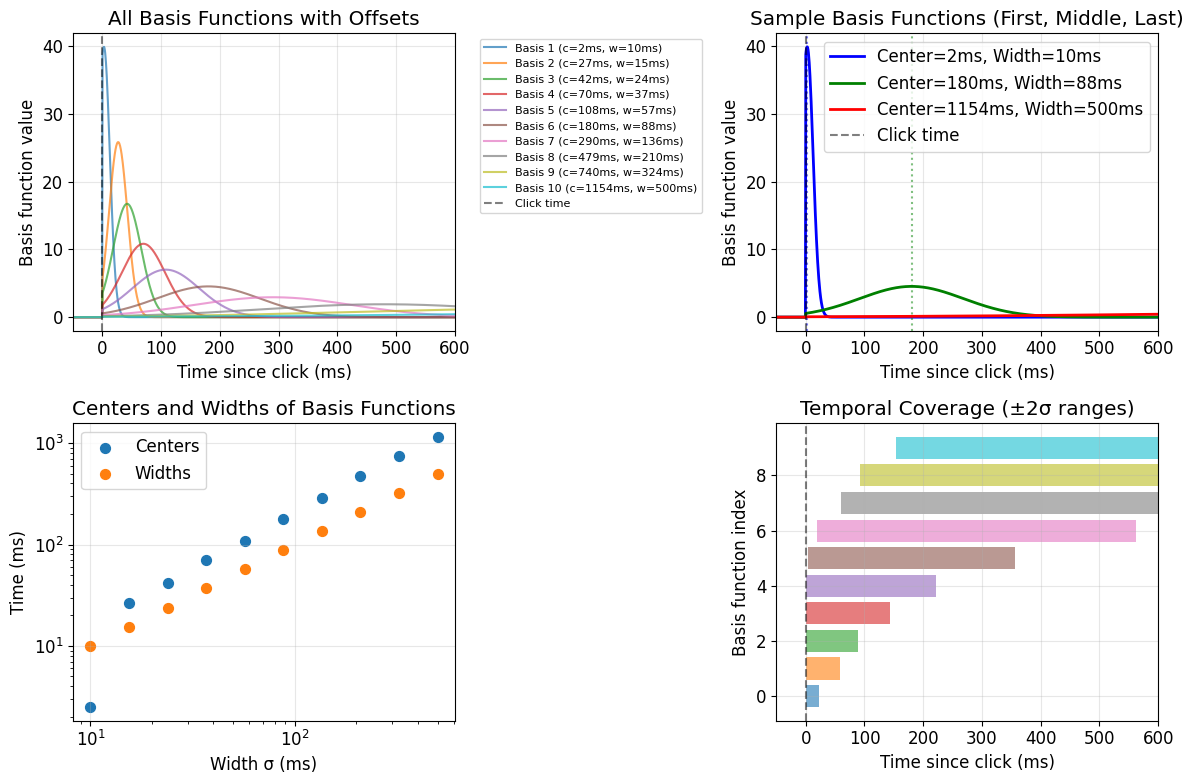

In [1089]:
# Visualize basis functions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Time axis for plotting
t_plot = np.linspace(-0.05, 0.6, 1000)

# Plot 1: All basis functions overlaid
ax = axes[0, 0]
for i in range(n_basis):
    y = gaussian_basis(t_plot, centers[i], widths[i], causal=True)
    ax.plot(t_plot*1000, y, alpha=0.7, linewidth=1.5, 
            label=f'Basis {i+1} (c={centers[i]*1000:.0f}ms, w={widths[i]*1000:.0f}ms)')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Basis function value')
ax.set_title('All Basis Functions with Offsets')
ax.grid(True, alpha=0.3)
ax.set_xlim(-50, 600)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Plot 2: Sample basis functions (first, middle, last)
ax = axes[0, 1]
sample_indices = [0, n_basis//2, n_basis-1]
colors = ['blue', 'green', 'red']
for idx, color in zip(sample_indices, colors):
    y = gaussian_basis(t_plot, centers[idx], widths[idx], causal=True)
    ax.plot(t_plot*1000, y, color=color, linewidth=2, 
            label=f'Center={centers[idx]*1000:.0f}ms, Width={widths[idx]*1000:.0f}ms')
    ax.axvline(centers[idx]*1000, color=color, linestyle=':', alpha=0.5)
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Basis function value')
ax.set_title('Sample Basis Functions (First, Middle, Last)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(-50, 600)

# Plot 3: Centers and widths vs width scale
ax = axes[1, 0]
ax.scatter(widths*1000, centers*1000, label='Centers', s=50)
ax.scatter(widths*1000, widths*1000, label='Widths', s=50)
ax.set_xlabel('Width σ (ms)')
ax.set_ylabel('Time (ms)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Centers and Widths of Basis Functions')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Coverage visualization
ax = axes[1, 1]
for i in range(n_basis):
    # Show ±2σ range for each basis
    left = max(0, centers[i] - 2*widths[i])  # Causal constraint
    right = centers[i] + 2*widths[i]
    ax.barh(i, (right - left)*1000, left=left*1000, height=0.8, 
            alpha=0.6, label=f'Basis {i+1}' if i < 3 else '')
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Basis function index')
ax.set_title('Temporal Coverage (±2σ ranges)')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.grid(True, alpha=0.3)
ax.set_xlim(-50, 600)

plt.tight_layout()
plt.show()

## 3. Feature Engineering: Convolve Clicks with Basis Functions

For each DV time point, create feature vectors by convolving click history with Gaussian basis functions.

In [1090]:
def create_trial_features(trial_clicks_left, trial_clicks_right, dv_eval_times, centers, widths, trial_duration, store_convolutions=False):
    """
    Create feature matrix for entire trial using fine temporal binning with offset Gaussian convolution
    
    This approach:
    1. Creates fine temporal bins at 5ms resolution for entire trial duration
    2. Places unit impulses (delta functions) at all click times
    3. Convolves with causal Gaussian basis functions (centered at different offsets, varying widths)
    4. Subsamples the convolved signals at DV evaluation time points
    
    Args:
        trial_clicks_left: Array of left click times for this trial
        trial_clicks_right: Array of right click times for this trial  
        dv_eval_times: Array of DV evaluation times for this trial
        centers: Basis function centers (temporal offsets in seconds)
        widths: Basis function widths (standard deviations in seconds)
        trial_duration: Duration of trial in seconds
        store_convolutions: If True, return full convolution outputs for visualization
    
    Returns:
        If store_convolutions=False:
            features_matrix: (n_dv_times, n_features) array where n_features = 2*n_basis
        If store_convolutions=True:
            features_matrix, stored_convolutions dict
    """
    # Fine temporal binning parameters
    dt = 0.005  # 5ms resolution (1/10th of 50ms DV resolution)
    
    # Create temporal grid for entire trial - extend to handle edge effects
    # Add padding at the end for proper convolution
    max_kernel_extent = 6 * widths.max()  # Maximum kernel extent
    padded_duration = trial_duration + max_kernel_extent
    time_grid = np.arange(0, padded_duration + dt, dt)
    n_bins = len(time_grid)
    
    # Initialize click count arrays (unit impulses)
    clicks_left = np.zeros(n_bins)
    clicks_right = np.zeros(n_bins)
    
    # Bin clicks as unit impulses across entire trial
    for click_time in trial_clicks_left:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            if 0 <= bin_idx < n_bins:
                clicks_left[bin_idx] += 1  # Unit impulse (delta function)
    
    for click_time in trial_clicks_right:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            if 0 <= bin_idx < n_bins:
                clicks_right[bin_idx] += 1  # Unit impulse (delta function)
    
    # Initialize convolved signals storage
    n_dv_times = len(dv_eval_times)
    n_basis = len(widths)
    features_matrix = np.zeros((n_dv_times, 2 * n_basis))  # left + right features
    
    if store_convolutions:
        # Only store the unpadded portion for visualization
        actual_trial_bins = int(np.ceil(trial_duration / dt))
        stored_convolutions = {
            'left': [],
            'right': [],
            'time_grid': time_grid[:actual_trial_bins],
            'clicks_left': clicks_left[:actual_trial_bins],
            'clicks_right': clicks_right[:actual_trial_bins]
        }
    
    # For each basis function, convolve once and subsample
    for i, width in enumerate(widths):
        # Create causal Gaussian kernel centered at specified offset
        # Kernel represents response to a click with temporal offset
        max_lag = min(6 * widths[i], padded_duration)  # 6 standard deviations or padded duration
        kernel_n_bins = int(np.ceil(max_lag / dt)) + 1
        
        # Time since click: 0 = click time, dt = one bin after, etc.
        time_lags = np.arange(0, kernel_n_bins * dt, dt)
        
        # Create Gaussian centered at specified offset (peak at center[i] after click)
        # No [::-1] needed - we want the kernel to start with max value
        causal_kernel = gaussian_basis(time_lags, centers[i], widths[i], causal=True)
        
        # # Normalize kernel to preserve total weight
        # if causal_kernel.sum() > 0:
        #     causal_kernel = causal_kernel / causal_kernel.sum()
        
        # Convolve clicks with causal kernel using 'full' mode for proper padding
        # Then trim to original size
        conv_left_full = np.convolve(clicks_left, causal_kernel, mode='full')
        conv_right_full = np.convolve(clicks_right, causal_kernel, mode='full')
        
        # Trim to match original grid size
        conv_left = conv_left_full[:n_bins]
        conv_right = conv_right_full[:n_bins]
        
        if store_convolutions:
            # Store only the trial portion (not the padding)
            actual_trial_bins = len(stored_convolutions['time_grid'])
            stored_convolutions['left'].append(conv_left[:actual_trial_bins])
            stored_convolutions['right'].append(conv_right[:actual_trial_bins])
        
        # Subsample convolved signals at DV evaluation times
        for j, eval_time in enumerate(dv_eval_times):
            # Find the time bin corresponding to eval_time
            eval_bin = int(np.floor(eval_time / dt))
            if 0 <= eval_bin < n_bins:
                features_matrix[j, i] = conv_left[eval_bin]  # Left feature
                features_matrix[j, i + n_basis] = conv_right[eval_bin]  # Right feature
    
    if store_convolutions:
        return features_matrix, stored_convolutions
    else:
        return features_matrix

# Test the new implementation
test_trial = 5
trial_clicks = click_df_240[click_df_240['trial_id'] == test_trial]
left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values

# Get the actual trial data for proper processing
trial_dvs = dv_df_240[dv_df_240['trial_id'] == test_trial]

# Get trial duration from DV data (max time_bin)
if len(trial_dvs) > 0:
    trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
else:
    trial_duration = 2.0

print(f"Test trial {test_trial} (offset Gaussians with proper centers):")
print(f"Left clicks: {len(left_clicks)}")
print(f"Right clicks: {len(right_clicks)}")
print(f"Trial duration: {trial_duration:.3f}s")

# Test with storing convolutions for visualization
if len(trial_dvs) > 0:
    dv_times = trial_dvs['time_bin'].values
    features_matrix, stored_convs = create_trial_features(
        left_clicks, right_clicks, dv_times, centers, widths, trial_duration, store_convolutions=True
    )
    
    print(f"\nFeatures matrix shape: {features_matrix.shape}")
    print(f"Features range: [{features_matrix.min():.4f}, {features_matrix.max():.4f}]")
    print(f"Number of stored convolutions: {len(stored_convs['left'])} per side")
    print("✓ Fixed convolution implementation with offset Gaussian centers!")

Test trial 5 (offset Gaussians with proper centers):
Left clicks: 5
Right clicks: 8
Trial duration: 1.075s

Features matrix shape: (22, 20)
Features range: [0.0000, 75.3063]
Number of stored convolutions: 10 per side
✓ Fixed convolution implementation with offset Gaussian centers!


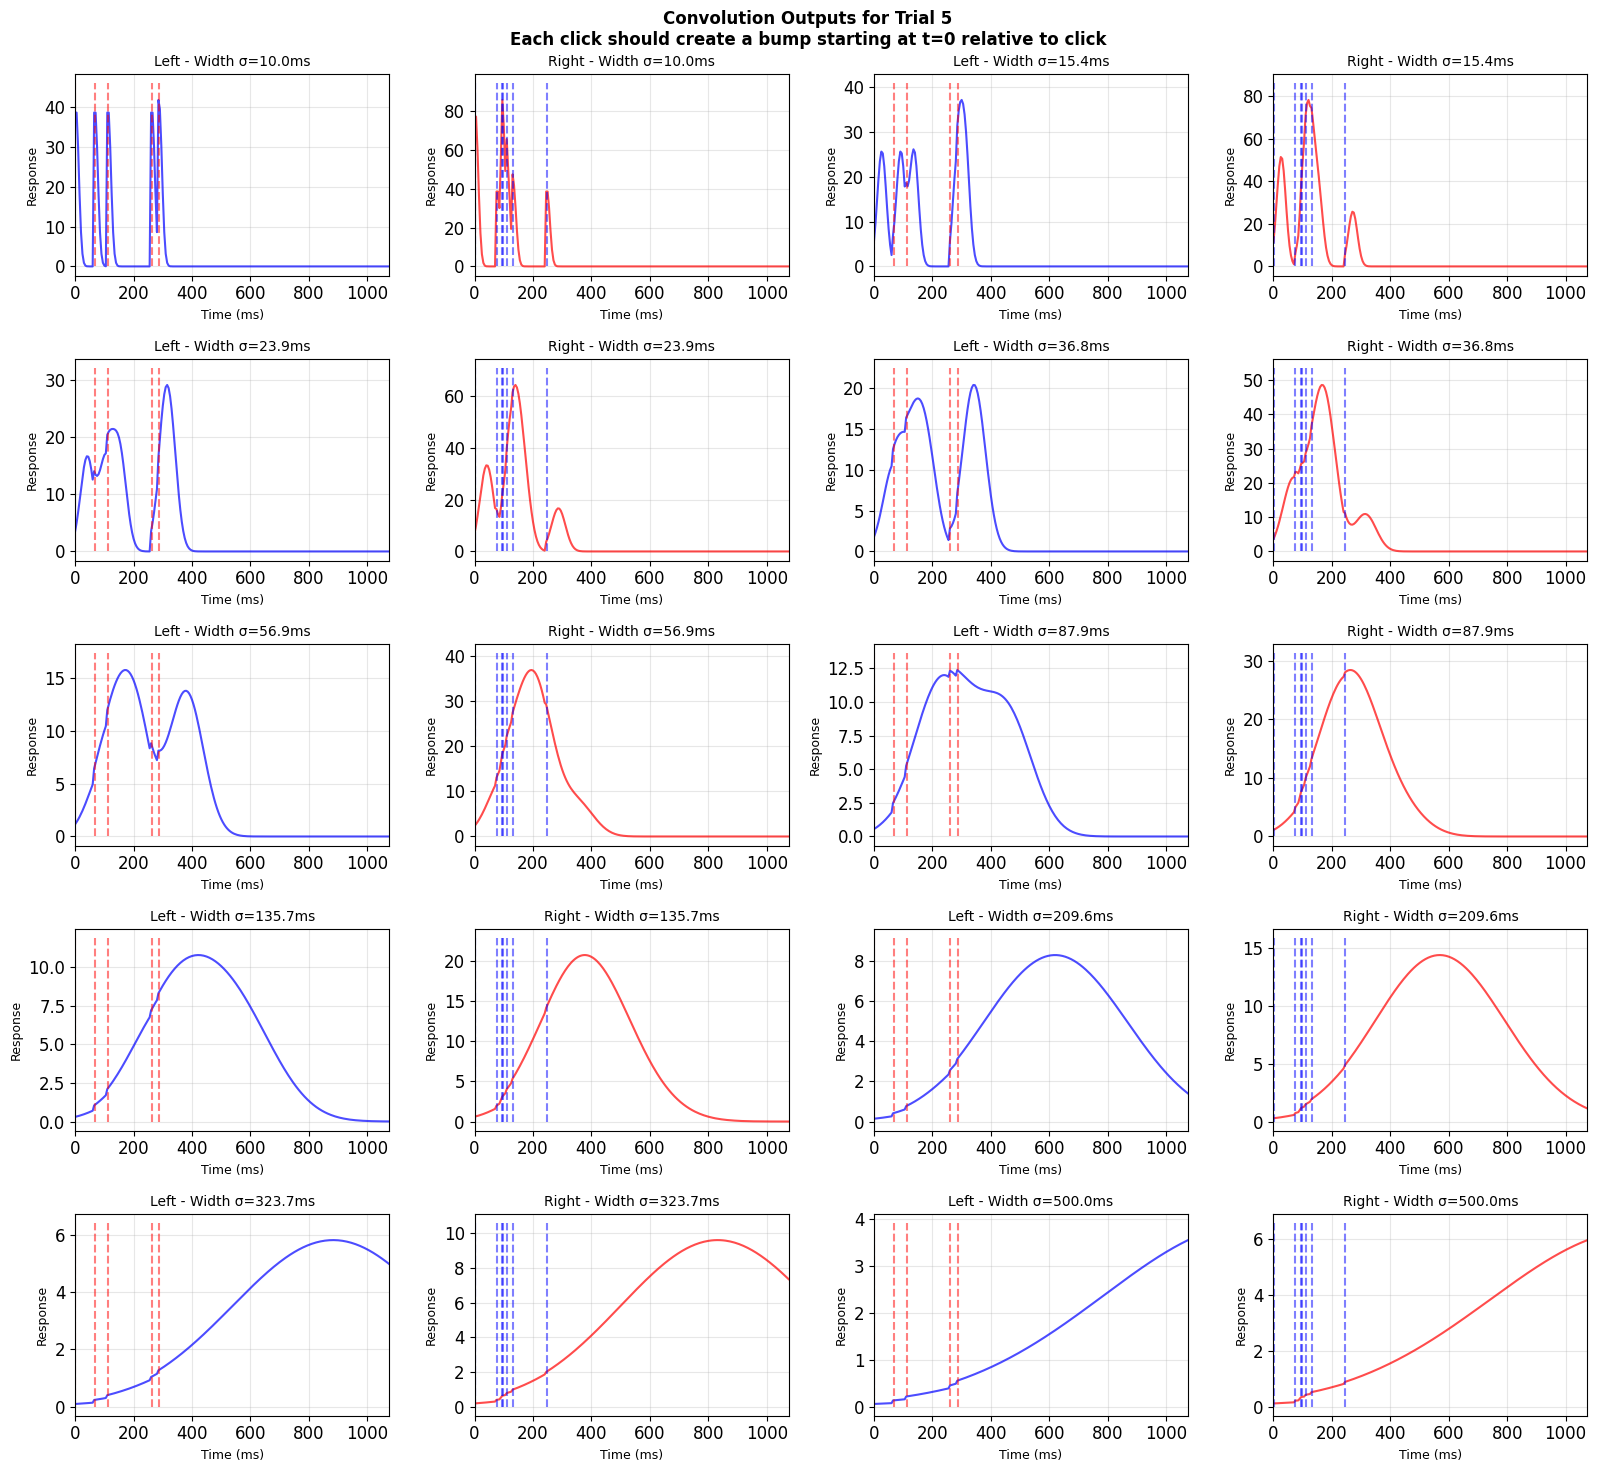


=== MONOTONICITY CHECK ===

Width σ=10.0ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 5
  Left monotonically decreasing: False
  Right monotonically decreasing: False

Width σ=15.4ms:
  Left clicks: 5, Peaks found: 5
  Right clicks: 8, Peaks found: 3
  Left monotonically decreasing: False
  Right monotonically decreasing: False

Width σ=23.9ms:
  Left clicks: 5, Peaks found: 4
  Right clicks: 8, Peaks found: 3
  Left monotonically decreasing: False
  Right monotonically decreasing: False

✓ Visualization complete - each click should create a visible bump!


In [1091]:
# Visualize convolutions to verify non-monotonic behavior (should show bumps at each click)
if len(stored_convs) > 0:
    fig, axes = plt.subplots(5, 4, figsize=(16, 15))
    axes = axes.flatten()
    
    time_ms = stored_convs['time_grid'][:len(stored_convs['left'][i])] * 1000  # Convert to milliseconds
    
    for i in range(min(n_basis, 10)):
        # Left convolutions
        ax_left = axes[i * 2]
        ax_left.plot(time_ms, stored_convs['left'][i][:len(time_ms)], 'b-', alpha=0.7, linewidth=1.5)
        ax_left.vlines(left_clicks * 1000, 0, max(stored_convs['left'][i]) * 1.1, 
                       colors='red', alpha=0.5, linestyles='dashed', label='Clicks')
        ax_left.set_title(f'Left - Width σ={widths[i]*1000:.1f}ms', fontsize=10)
        ax_left.set_xlabel('Time (ms)', fontsize=9)
        ax_left.set_ylabel('Response', fontsize=9)
        ax_left.grid(True, alpha=0.3)
        ax_left.set_xlim([0, trial_duration * 1000])
        
        # Right convolutions  
        ax_right = axes[i * 2 + 1]
        ax_right.plot(time_ms, stored_convs['right'][i][:len(time_ms)], 'r-', alpha=0.7, linewidth=1.5)
        ax_right.vlines(right_clicks * 1000, 0, max(stored_convs['right'][i]) * 1.1,
                        colors='blue', alpha=0.5, linestyles='dashed', label='Clicks')
        ax_right.set_title(f'Right - Width σ={widths[i]*1000:.1f}ms', fontsize=10)
        ax_right.set_xlabel('Time (ms)', fontsize=9)
        ax_right.set_ylabel('Response', fontsize=9)
        ax_right.grid(True, alpha=0.3)
        ax_right.set_xlim([0, trial_duration * 1000])
    
    plt.suptitle(f'Convolution Outputs for Trial {test_trial}\nEach click should create a bump starting at t=0 relative to click', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Check for monotonic decrease
    print("\n=== MONOTONICITY CHECK ===")
    for i in range(min(3, n_basis)):  # Check first 3 widths
        conv_left_i = stored_convs['left'][i]
        conv_right_i = stored_convs['right'][i]
        
        # Find peaks in convolution (should correspond to clicks)
        from scipy.signal import find_peaks
        peaks_left, _ = find_peaks(conv_left_i, height=max(conv_left_i) * 0.1)
        peaks_right, _ = find_peaks(conv_right_i, height=max(conv_right_i) * 0.1)
        
        print(f"\nWidth σ={widths[i]*1000:.1f}ms:")
        print(f"  Left clicks: {len(left_clicks)}, Peaks found: {len(peaks_left)}")
        print(f"  Right clicks: {len(right_clicks)}, Peaks found: {len(peaks_right)}")
        
        # Check if monotonically decreasing
        is_monotonic_left = all(conv_left_i[j] >= conv_left_i[j+1] for j in range(len(conv_left_i)-1))
        is_monotonic_right = all(conv_right_i[j] >= conv_right_i[j+1] for j in range(len(conv_right_i)-1))
        
        print(f"  Left monotonically decreasing: {is_monotonic_left}")
        print(f"  Right monotonically decreasing: {is_monotonic_right}")
    
    print("\n✓ Visualization complete - each click should create a visible bump!")

## 4. Build Design Matrix for GLM

Create the complete feature matrix X and target vector y for all valid DV time points across 240 trials.

In [1092]:
# Build feature matrix X and target vector y using efficient trial-level processing
print("Building feature matrix with OFFSET Gaussian convolution...")

X = []
y = []
valid_mask = []
trial_ids = []
time_bins = []

# Progress tracking
from tqdm import tqdm

# Only process first 240 trials as specified
n_trials_to_process = min(240, dv_df_240['trial_id'].max() + 1)

for trial_id in tqdm(range(n_trials_to_process), desc="Processing trials"):
    # Get clicks for this trial - use time_from_first_click to match test above
    trial_clicks = click_df_240[click_df_240['trial_id'] == trial_id]
    left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
    right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
    
    # Get DVs for this trial
    trial_dvs = dv_df_240[dv_df_240['trial_id'] == trial_id]
    
    if len(trial_dvs) > 0:
        # Extract DV evaluation times 
        dv_eval_times = trial_dvs['time_bin'].values
        
        # Get trial duration from DV data (max time_bin represents time_from_first_click)
        # Add small buffer to ensure we capture the full trial
        trial_duration = trial_dvs['time_bin'].max() + 0.05  # 50ms buffer
        
        # Use CORRECTED trial-level feature creation with offset Gaussian centers
        try:
            features_matrix = create_trial_features(
                left_clicks, right_clicks, dv_eval_times, centers, widths, trial_duration
            )
            
            # Add features and targets for all DV time points in this trial
            for i, (_, dv_row) in enumerate(trial_dvs.iterrows()):
                X.append(features_matrix[i])
                y.append(dv_row['decision_variable'])
                valid_mask.append(dv_row['is_valid'])
                trial_ids.append(trial_id)
                time_bins.append(dv_row['time_bin'])
                
        except Exception as e:
            print(f"Warning: Error processing trial {trial_id}: {e}")
            # Skip this trial if there's an error
            continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
valid_mask = np.array(valid_mask)
trial_ids = np.array(trial_ids)
time_bins = np.array(time_bins)

print(f"\nFeature matrix constructed with OFFSET Gaussian convolution:")
print(f"Total observations: {len(X)}")
print(f"Features per observation: {X.shape[1]}")
print(f"Valid observations: {valid_mask.sum()}")
print(f"Invalid observations: {(~valid_mask).sum()}")

# Keep only valid DV points
X_valid = X[valid_mask]
y_valid = y[valid_mask]
trial_ids_valid = trial_ids[valid_mask]
time_bins_valid = time_bins[valid_mask]

print(f"\nFinal dataset for GLM:")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
print(f"Data covers {len(np.unique(trial_ids_valid))} unique trials")

# Compare with old approach efficiency metrics
print(f"\n=== EFFICIENCY COMPARISON ===")
print("New approach: Convolve once per trial, subsample at DV times")
print("Old approach: Convolve separately for each DV time point")
total_dv_points = len(X)
unique_trials = len(np.unique(trial_ids))
print(f"Convolutions needed - Old: {total_dv_points}, New: {unique_trials} x {n_basis} = {unique_trials * n_basis}")
print(f"Efficiency gain: {total_dv_points / (unique_trials * n_basis):.1f}x fewer convolutions")
print("\n✓ Using OFFSET Gaussian convolution with centers for improved temporal coverage!")

Building feature matrix with OFFSET Gaussian convolution...


Processing trials: 100%|██████████| 240/240 [00:00<00:00, 407.28it/s]


Feature matrix constructed with OFFSET Gaussian convolution:
Total observations: 5280
Features per observation: 20
Valid observations: 4266
Invalid observations: 1014

Final dataset for GLM:
X_valid shape: (4266, 20)
y_valid shape: (4266,)
Data covers 240 unique trials

=== EFFICIENCY COMPARISON ===
New approach: Convolve once per trial, subsample at DV times
Old approach: Convolve separately for each DV time point
Convolutions needed - Old: 5280, New: 240 x 10 = 2400
Efficiency gain: 2.2x fewer convolutions

✓ Using OFFSET Gaussian convolution with centers for improved temporal coverage!


In [1093]:
# Feature matrix validation and summary statistics
print("=== FEATURE MATRIX ANALYSIS ===\n")

# Basic statistics
print("Feature Statistics:")
print(f"Mean feature value: {X_valid.mean():.6f}")
print(f"Std feature value: {X_valid.std():.6f}")
print(f"Min feature value: {X_valid.min():.6f}")
print(f"Max feature value: {X_valid.max():.6f}")

# Sparsity analysis
zero_features = (X_valid == 0).sum()
total_features = X_valid.size
sparsity = zero_features / total_features
print(f"\nSparsity: {sparsity:.3f} ({zero_features}/{total_features} zeros)")

# Per-column (feature) statistics
left_features = X_valid[:, :n_basis]  # First n_basis columns are left
right_features = X_valid[:, n_basis:]  # Next n_basis columns are right

print(f"\nLeft click features:")
print(f"  Mean: {left_features.mean():.6f}, Std: {left_features.std():.6f}")
print(f"  Non-zero: {(left_features > 0).sum()} / {left_features.size}")

print(f"\nRight click features:")
print(f"  Mean: {right_features.mean():.6f}, Std: {right_features.std():.6f}")
print(f"  Non-zero: {(right_features > 0).sum()} / {right_features.size}")

# Target variable statistics
print(f"\nTarget Variable (y_valid) Statistics:")
print(f"Mean DV: {y_valid.mean():.3f}")
print(f"Std DV: {y_valid.std():.3f}")
print(f"Min DV: {y_valid.min():.3f}")
print(f"Max DV: {y_valid.max():.3f}")

# Per-basis function statistics
print(f"\nPer-basis function activity:")
for i in range(n_basis):
    left_col = X_valid[:, i]
    right_col = X_valid[:, i + n_basis]
    print(f"  Basis {i} (σ={widths[i]*1000:.1f}ms): L={left_col.mean():.4f}, R={right_col.mean():.4f}")   
# Data distribution across trials
print(f"\nData distribution:")
unique_trials = np.unique(trial_ids_valid)
obs_per_trial = [np.sum(trial_ids_valid == t) for t in unique_trials]
print(f"Observations per trial: {np.mean(obs_per_trial):.1f} ± {np.std(obs_per_trial):.1f}")
print(f"Range: {np.min(obs_per_trial)} - {np.max(obs_per_trial)} obs/trial")

=== FEATURE MATRIX ANALYSIS ===

Feature Statistics:
Mean feature value: 11.965694
Std feature value: 15.237673
Min feature value: 0.000000
Max feature value: 112.503016

Sparsity: 0.167 (14212/85320 zeros)

Left click features:
  Mean: 11.878379, Std: 14.752706
  Non-zero: 35403 / 42660

Right click features:
  Mean: 12.053009, Std: 15.707189
  Non-zero: 35705 / 42660

Target Variable (y_valid) Statistics:
Mean DV: 0.604
Std DV: 9.668
Min DV: -31.808
Max DV: 31.767

Per-basis function activity:
  Basis 0 (σ=10.0ms): L=11.2092, R=11.1860
  Basis 1 (σ=15.4ms): L=15.9266, R=16.2961
  Basis 2 (σ=23.9ms): L=15.6348, R=16.0994
  Basis 3 (σ=36.8ms): L=15.7172, R=16.1059
  Basis 4 (σ=56.9ms): L=15.5492, R=15.8391
  Basis 5 (σ=87.9ms): L=14.8866, R=15.1013
  Basis 6 (σ=135.7ms): L=12.9880, R=13.1206
  Basis 7 (σ=209.6ms): L=9.3764, R=9.3467
  Basis 8 (σ=323.7ms): L=5.2698, R=5.2290
  Basis 9 (σ=500.0ms): L=2.2261, R=2.2059

Data distribution:
Observations per trial: 17.8 ± 4.5
Range: 7 - 22 ob

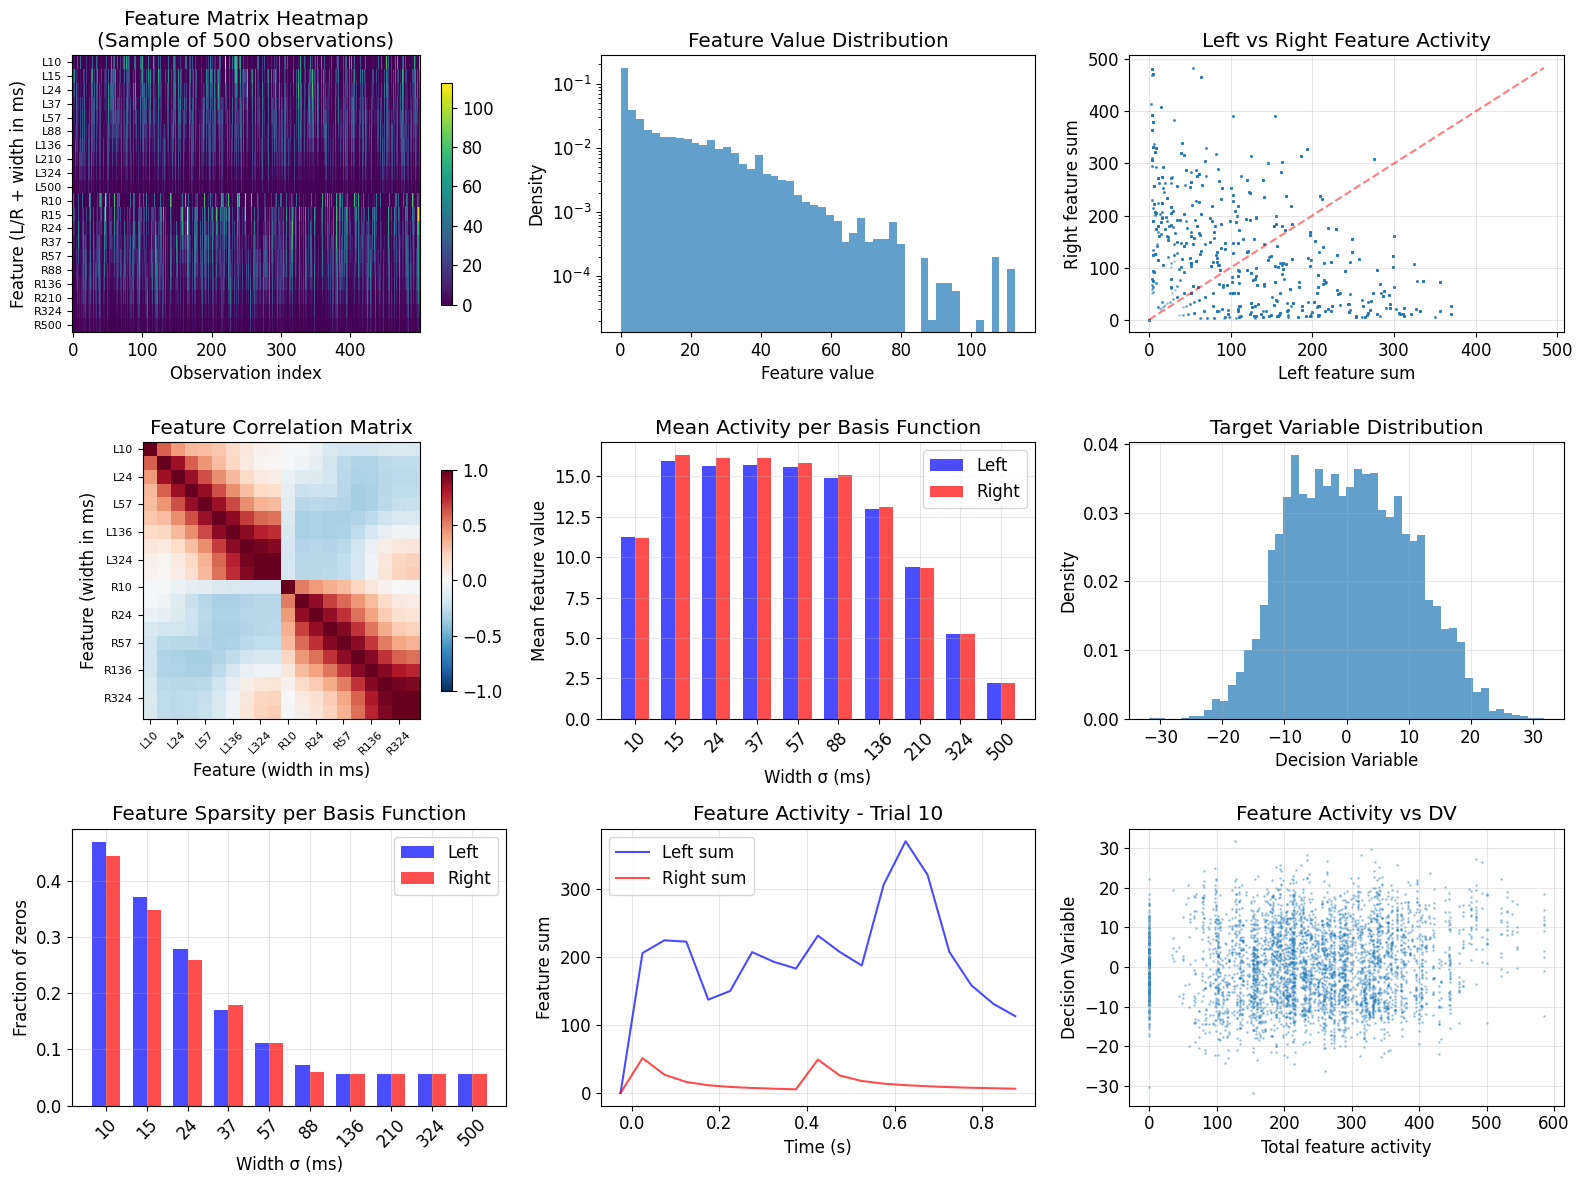

Feature matrix visualization complete!


In [1094]:
# Visualize feature matrix structure and patterns
plt.figure(figsize=(16, 12))

# 1. Feature matrix heatmap (sample)
plt.subplot(3, 3, 1)
sample_idx = np.random.choice(len(X_valid), size=min(500, len(X_valid)), replace=False)
X_sample = X_valid[sample_idx]
im = plt.imshow(X_sample.T, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im, shrink=0.8)
plt.xlabel('Observation index')
# Create custom y-tick labels showing widths
ytick_labels = [f'L{w:.0f}' for w in widths*1000] + [f'R{w:.0f}' for w in widths*1000]
plt.yticks(range(20), ytick_labels, fontsize=8)
plt.ylabel('Feature (L/R + width in ms)')
plt.title(f'Feature Matrix Heatmap\n(Sample of {len(sample_idx)} observations)')

# 2. Feature distributions
plt.subplot(3, 3, 2)
plt.hist(X_valid.flatten(), bins=50, alpha=0.7, density=True)
plt.xlabel('Feature value')
plt.ylabel('Density')
plt.title('Feature Value Distribution')
plt.yscale('log')

# 3. Left vs Right feature sums
plt.subplot(3, 3, 3)
left_sums = left_features.sum(axis=1)
right_sums = right_features.sum(axis=1)
plt.scatter(left_sums, right_sums, alpha=0.3, s=1)
plt.xlabel('Left feature sum')
plt.ylabel('Right feature sum')
plt.title('Left vs Right Feature Activity')
plt.plot([0, max(left_sums.max(), right_sums.max())], [0, max(left_sums.max(), right_sums.max())], 'r--', alpha=0.5)
plt.grid(True, alpha=0.3)

# 4. Feature correlation matrix with width labels
plt.subplot(3, 3, 4)
feature_corr = np.corrcoef(X_valid.T)
im = plt.imshow(feature_corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im, shrink=0.8)
# Create tick labels with widths
tick_labels = [f'L{w:.0f}' for w in widths*1000] + [f'R{w:.0f}' for w in widths*1000]
plt.xticks(range(0, 20, 2), tick_labels[::2], rotation=45, fontsize=8)
plt.yticks(range(0, 20, 2), tick_labels[::2], fontsize=8)
plt.xlabel('Feature (width in ms)')
plt.ylabel('Feature (width in ms)')
plt.title('Feature Correlation Matrix')

# 5. Mean feature activity per basis function (using widths on x-axis)
plt.subplot(3, 3, 5)
mean_left = left_features.mean(axis=0)
mean_right = right_features.mean(axis=0)
# For log scale, we need to position bars explicitly
x_positions = np.arange(n_basis)  # Use indices for bar positions
bar_width = 0.35
plt.bar(x_positions - bar_width/2, mean_left, bar_width, label='Left', color='blue', alpha=0.7)
plt.bar(x_positions + bar_width/2, mean_right, bar_width, label='Right', color='red', alpha=0.7)
# Set custom x-tick labels with widths
plt.xticks(x_positions, [f'{w:.0f}' for w in widths*1000], rotation=45)
plt.xlabel('Width σ (ms)')
plt.ylabel('Mean feature value')
plt.title('Mean Activity per Basis Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Target variable distribution
plt.subplot(3, 3, 6)
plt.hist(y_valid, bins=50, alpha=0.7, density=True)
plt.xlabel('Decision Variable')
plt.ylabel('Density')
plt.title('Target Variable Distribution')
plt.grid(True, alpha=0.3)

# 7. Feature sparsity per basis function (using widths on x-axis)
plt.subplot(3, 3, 7)
left_sparsity = [(left_features[:, i] == 0).mean() for i in range(n_basis)]
right_sparsity = [(right_features[:, i] == 0).mean() for i in range(n_basis)]
x_positions = np.arange(n_basis)  # Use indices for bar positions
plt.bar(x_positions - bar_width/2, left_sparsity, bar_width, label='Left', color='blue', alpha=0.7)
plt.bar(x_positions + bar_width/2, right_sparsity, bar_width, label='Right', color='red', alpha=0.7)
# Set custom x-tick labels with widths
plt.xticks(x_positions, [f'{w:.0f}' for w in widths*1000], rotation=45)
plt.xlabel('Width σ (ms)')
plt.ylabel('Fraction of zeros')
plt.title('Feature Sparsity per Basis Function')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Time series of feature activity (sample trial)
plt.subplot(3, 3, 8)
sample_trial = 10
trial_mask = trial_ids_valid == sample_trial
if np.any(trial_mask):
    trial_times = time_bins_valid[trial_mask]
    trial_features = X_valid[trial_mask]
    plt.plot(trial_times, trial_features[:, :n_basis].sum(axis=1), 'b-', alpha=0.7, label='Left sum')
    plt.plot(trial_times, trial_features[:, n_basis:].sum(axis=1), 'r-', alpha=0.7, label='Right sum')
    plt.xlabel('Time (s)')
    plt.ylabel('Feature sum')
    plt.title(f'Feature Activity - Trial {sample_trial}')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 9. Feature vs target scatter (total activity)
plt.subplot(3, 3, 9)
total_activity = X_valid.sum(axis=1)
plt.scatter(total_activity, y_valid, alpha=0.3, s=1)
plt.xlabel('Total feature activity')
plt.ylabel('Decision Variable')
plt.title('Feature Activity vs DV')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Feature matrix visualization complete!")

## 5. Train Model

In [1095]:
## Fit ElasticNetCV Model

# Split into train/validation sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

# Add small noise to features to reduce striations
# Noise level is 1% of each feature's standard deviation
noise_level = 0.01
X_train_std = X_train.std(axis=0)
X_test_std = X_test.std(axis=0)

# Avoid division by zero for features with no variance
X_train_std[X_train_std == 0] = 1.0
X_test_std[X_test_std == 0] = 1.0

# Add proportional noise to each feature
np.random.seed(42)  # For reproducibility
X_train_noisy = X_train + np.random.normal(0, noise_level * X_train_std, X_train.shape)
X_test_noisy = X_test + np.random.normal(0, noise_level * X_test_std, X_test.shape)

print(f"Added {noise_level*100:.1f}% noise to features to reduce discretization")

# Standardize features for sklearn - COMMENTED OUT TO USE RAW FEATURES
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Configure ElasticNetCV with l1_ratio=0.95 (95% L1, 5% L2)
model = ElasticNetCV(
    l1_ratio=0.95,  # 95% Lasso, 5% Ridge
    cv=10,  # 10-fold cross-validation
    n_alphas=100,  # Test 100 regularization values
    max_iter=10000,  # Ensure convergence
    selection='cyclic',  # Stable for low dimensions
    random_state=42
)

# Fit the model on training data - USING NOISY FEATURES
print('Fitting ElasticNetCV model with l1_ratio=0.95 (no StandardScaler, with noise)...')
model.fit(X_train_noisy, y_train)  # Using noisy features

# Get predictions - USING NOISY FEATURES
y_pred_train = model.predict(X_train_noisy)  # Using noisy features
y_pred_test = model.predict(X_test_noisy)    # Using noisy features

# Extract coefficients
coefficients = model.coef_
n_features_selected = np.sum(coefficients != 0)

# Calculate metrics
train_corr = np.corrcoef(y_train, y_pred_train)[0,1]
test_corr = np.corrcoef(y_test, y_pred_test)[0,1]
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'\nModel Performance:')
print(f'Selected features: {n_features_selected}/{len(coefficients)}')
print(f'Optimal alpha: {model.alpha_:.6f}')
print(f'\nTrain set ({len(y_train)} samples):')
print(f'  Correlation: {train_corr:.4f}')
print(f'  R²: {train_r2:.4f}')
print(f'  RMSE/std: {train_rmse/np.std(y_train):.4f}')
print(f'\nTest set ({len(y_test)} samples):')
print(f'  Correlation: {test_corr:.4f}')
print(f'  R²: {test_r2:.4f}')
print(f'  RMSE/std: {test_rmse/np.std(y_test):.4f}')
print('\nNote: Using raw features with Gaussian normalization, no StandardScaler')
print(f'Added {noise_level*100:.1f}% noise to reduce striations')

Added 1.0% noise to features to reduce discretization
Fitting ElasticNetCV model with l1_ratio=0.95 (no StandardScaler, with noise)...

Model Performance:
Selected features: 13/20
Optimal alpha: 0.569882

Train set (3412 samples):
  Correlation: 0.6268
  R²: 0.3928
  RMSE/std: 0.7792

Test set (854 samples):
  Correlation: 0.6349
  R²: 0.4012
  RMSE/std: 0.7738

Note: Using raw features with Gaussian normalization, no StandardScaler
Added 1.0% noise to reduce striations


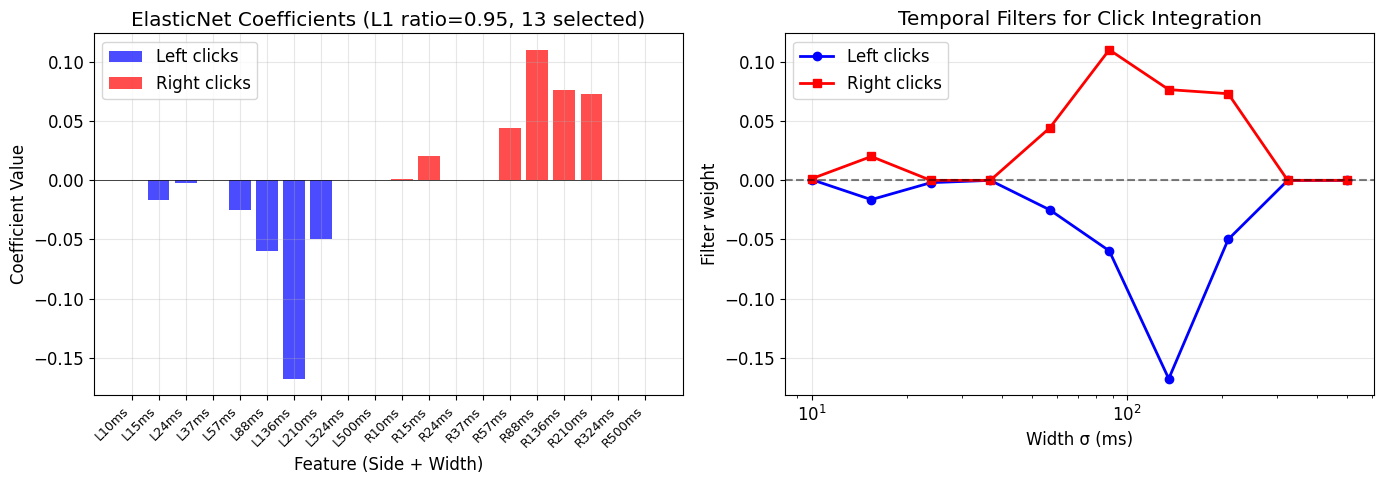


Selected features: 13
Selected widths and coefficients:
  Left @ σ=10.0ms: 0.0006
  Left @ σ=15.4ms: -0.0163
  Left @ σ=23.9ms: -0.0020
  Left @ σ=56.9ms: -0.0250
  Left @ σ=87.9ms: -0.0596
  Left @ σ=135.7ms: -0.1678
  Left @ σ=209.6ms: -0.0499
  Right @ σ=10.0ms: 0.0014
  Right @ σ=15.4ms: 0.0202
  Right @ σ=56.9ms: 0.0444
  Right @ σ=87.9ms: 0.1104
  Right @ σ=135.7ms: 0.0768
  Right @ σ=209.6ms: 0.0733


In [1096]:
## Visualize Model Coefficients

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Coefficient values with width labels
ax = axes[0]
x_pos = np.arange(len(coefficients))
colors = ['blue'] * (len(coefficients)//2) + ['red'] * (len(coefficients)//2)
bars = ax.bar(x_pos, coefficients, color=colors, alpha=0.7)

# Create custom x-tick labels showing side and width
xtick_labels = [f'L{w:.0f}ms' for w in widths*1000] + [f'R{w:.0f}ms' for w in widths*1000]
ax.set_xticks(x_pos)
ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontsize=9)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Feature (Side + Width)')
ax.set_ylabel('Coefficient Value')
ax.set_title(f'ElasticNet Coefficients (L1 ratio=0.95, {n_features_selected} selected)')
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Left clicks'),
                   Patch(facecolor='red', alpha=0.7, label='Right clicks')]
ax.legend(handles=legend_elements)

# Plot 2: Temporal filters using actual widths
ax = axes[1]
n_basis = len(coefficients) // 2
left_coefs = coefficients[:n_basis]
right_coefs = coefficients[n_basis:]

# Use actual widths for x-axis
ax.plot(widths * 1000, left_coefs, 'b-', marker='o', label='Left clicks', linewidth=2)
ax.plot(widths * 1000, right_coefs, 'r-', marker='s', label='Right clicks', linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Width σ (ms)')
ax.set_ylabel('Filter weight')
ax.set_title('Temporal Filters for Click Integration')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Print selected features with widths
selected_idx = np.where(coefficients != 0)[0]
if len(selected_idx) > 0:
    print(f'\nSelected features: {n_features_selected}')
    print(f'Selected widths and coefficients:')
    for idx in selected_idx:
        if idx < n_basis:
            print(f'  Left @ σ={widths[idx]*1000:.1f}ms: {coefficients[idx]:.4f}')
        else:
            print(f'  Right @ σ={widths[idx-n_basis]*1000:.1f}ms: {coefficients[idx]:.4f}')

## 6. Visualizations

Create comprehensive visualizations of the GLM results, including cross-validation performance, regularization behavior, learned temporal filters, and model fit quality.

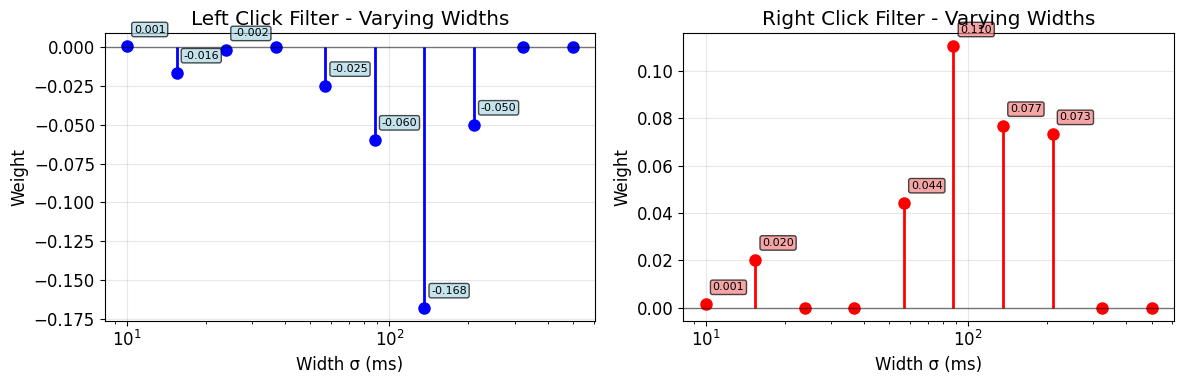

=== LEARNED TEMPORAL FILTERS ===
Left click features selected: 7/10
Right click features selected: 6/10
Active left widths: [ 10.   15.4  23.9  56.9  87.9 135.7 209.6] ms
Active right widths: [ 10.   15.4  56.9  87.9 135.7 209.6] ms
Total left filter strength: 0.3211
Total right filter strength: 0.3265
L/R filter ratio: 0.98
✓ Temporal filters reveal learned click-to-DV relationships


In [1097]:
# 3. Learned temporal filters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Left click filter
colors_left = ['blue' if c != 0 else 'lightgray' for c in left_coefs]
markerline, stemlines, baseline = ax1.stem(widths*1000, left_coefs, basefmt=' ')
plt.setp(markerline, color='blue', markersize=8)
plt.setp(stemlines, colors=colors_left, linewidth=2)
ax1.set_xlabel('Width σ (ms)')
ax1.set_ylabel('Weight')
ax1.set_title('Left Click Filter - Varying Widths')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, left_coefs)):
    if coef != 0:
        ax1.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightblue', alpha=0.7))

# Right click filter  
colors_right = ['red' if c != 0 else 'lightgray' for c in right_coefs]
markerline, stemlines, baseline = ax2.stem(widths*1000, right_coefs, basefmt=' ')
plt.setp(markerline, color='red', markersize=8)
plt.setp(stemlines, colors=colors_right, linewidth=2)
ax2.set_xlabel('Width σ (ms)')
ax2.set_ylabel('Weight')
ax2.set_title('Right Click Filter - Varying Widths')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linestyle='-', alpha=0.5, linewidth=1)

# Annotate selected features
for i, (width, coef) in enumerate(zip(widths, right_coefs)):
    if coef != 0:
        ax2.annotate(f'{coef:.3f}', 
                     xy=(width*1000, coef), 
                     xytext=(5, 10), 
                     textcoords='offset points',
                     fontsize=8, ha='left',
                     bbox=dict(boxstyle='round,pad=0.2', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

# Summary of learned filters
print("=== LEARNED TEMPORAL FILTERS ===")
left_selected = np.sum(left_coefs != 0)
right_selected = np.sum(right_coefs != 0)
print(f"Left click features selected: {left_selected}/{n_basis}")
print(f"Right click features selected: {right_selected}/{n_basis}")

if left_selected > 0:
    left_active_widths = widths[left_coefs != 0] * 1000
    print(f"Active left widths: {left_active_widths.round(1)} ms")

if right_selected > 0:
    right_active_widths = widths[right_coefs != 0] * 1000
    print(f"Active right widths: {right_active_widths.round(1)} ms")

# Compare filter strengths
left_total = np.sum(np.abs(left_coefs))
right_total = np.sum(np.abs(right_coefs))
print(f"Total left filter strength: {left_total:.4f}")
print(f"Total right filter strength: {right_total:.4f}")
print(f"L/R filter ratio: {left_total/right_total:.2f}" if right_total > 0 else "L/R filter ratio: inf")

print("✓ Temporal filters reveal learned click-to-DV relationships")

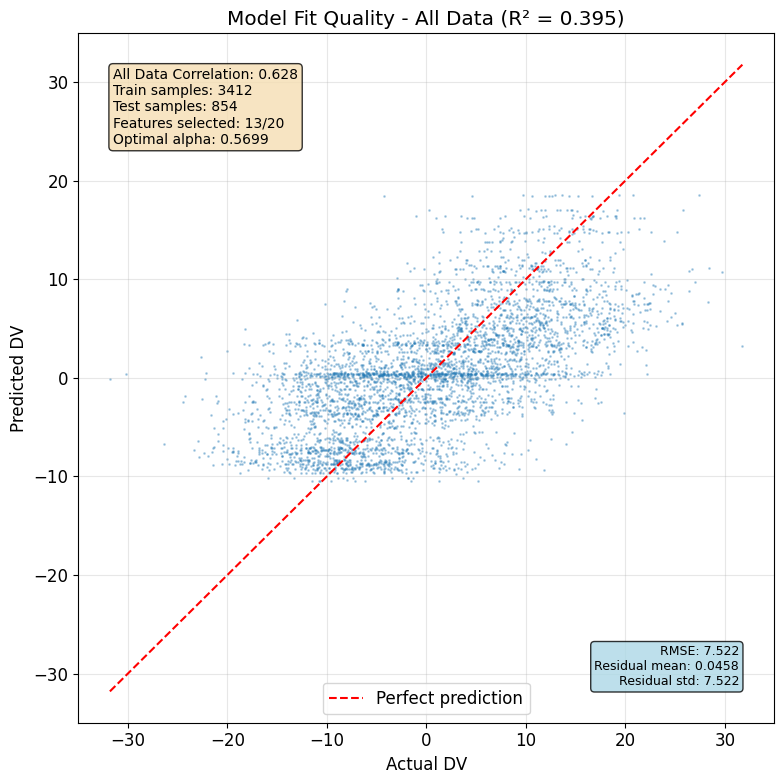

Total data points plotted: 4266


In [1098]:
# 4. Model fit quality - INCLUDING ALL DATA
# Combine train and test data for comprehensive view
y_all = np.concatenate([y_train, y_test])
y_pred_all = np.concatenate([y_pred_train, y_pred_test])

plt.figure(figsize=(8, 8))
plt.scatter(y_all, y_pred_all, alpha=0.3, s=1)
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()],
         'r--', label='Perfect prediction')
plt.xlabel('Actual DV')
plt.ylabel('Predicted DV')

# Calculate R² for all data
from sklearn.metrics import r2_score
r2_all = r2_score(y_all, y_pred_all)
plt.title(f'Model Fit Quality - All Data (R² = {r2_all:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add performance metrics as text
correlation_all = np.corrcoef(y_all, y_pred_all)[0,1]
textstr = f'''All Data Correlation: {correlation_all:.3f}
Train samples: {len(y_train)}
Test samples: {len(y_test)}
Features selected: {n_features_selected}/{len(coefficients)}
Optimal alpha: {model.alpha_:.4f}'''

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Add diagonal statistics for all data
residuals = y_all - y_pred_all
plt.text(0.95, 0.05, f'RMSE: {np.sqrt(np.mean(residuals**2)):.3f}\n'
                      f'Residual mean: {residuals.mean():.4f}\n'
                      f'Residual std: {residuals.std():.3f}',
         transform=plt.gca().transAxes, fontsize=9,
         verticalalignment='bottom', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Total data points plotted: {len(y_all)}")

## 7. Response Function Analysis

Construct and visualize the temporal response functions that show how clicks influence the decision variable over time.

In [1099]:
# Construct full temporal response functions by combining weighted basis functions
# Time range for response function visualization
t = np.linspace(-0.05, 1.5, 1550)  # -50ms to 1500ms at 1ms resolution

# Initialize response functions
left_response = np.zeros_like(t)
right_response = np.zeros_like(t)

# Get coefficients from the model
left_coefs = coefficients[:n_basis]
right_coefs = coefficients[n_basis:]

# Build response functions by summing weighted basis functions
for i in range(n_basis):
    if left_coefs[i] != 0:  # Only include non-zero coefficients
        left_response += left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
    if right_coefs[i] != 0:
        right_response += right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)

print(f"Response functions constructed from {n_features_selected} selected features")
print(f"Left response peak: {left_response.max():.4f} at {t[left_response.argmax()]*1000:.1f}ms")
print(f"Right response peak: {right_response.max():.4f} at {t[right_response.argmax()]*1000:.1f}ms")

Response functions constructed from 13 selected features
Left response peak: 0.0000 at -50.0ms
Right response peak: 0.8823 at 151.1ms


### 7.1 Combined Response Functions

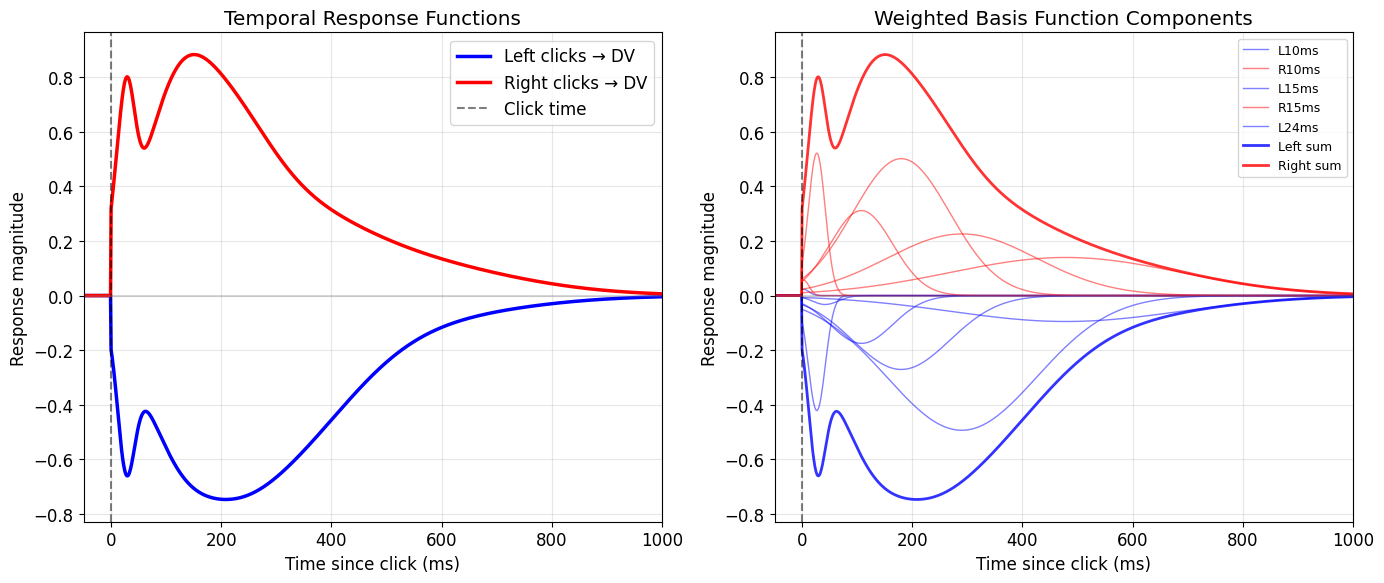

In [1100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Combined response functions
ax1.plot(t*1000, left_response, 'b-', linewidth=2.5, label='Left clicks → DV')
ax1.plot(t*1000, right_response, 'r-', linewidth=2.5, label='Right clicks → DV')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax1.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Time since click (ms)')
ax1.set_ylabel('Response magnitude')
ax1.set_title('Temporal Response Functions')
ax1.set_xlim(-50, 1000)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Right panel: Individual weighted components
ax2.set_title('Weighted Basis Function Components')
for i in range(n_basis):
    if left_coefs[i] != 0:
        weighted_basis = left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax2.plot(t*1000, weighted_basis, 'b-', alpha=0.5, linewidth=1, 
                label=f'L{widths[i]*1000:.0f}ms' if i < 3 else '')
    if right_coefs[i] != 0:
        weighted_basis = right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax2.plot(t*1000, weighted_basis, 'r-', alpha=0.5, linewidth=1,
                label=f'R{widths[i]*1000:.0f}ms' if i < 3 else '')

ax2.plot(t*1000, left_response, 'b-', linewidth=2, alpha=0.8, label='Left sum')
ax2.plot(t*1000, right_response, 'r-', linewidth=2, alpha=0.8, label='Right sum')
ax2.axvline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax2.set_xlabel('Time since click (ms)')
ax2.set_ylabel('Response magnitude')
ax2.set_xlim(-50, 1000)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.2 Cumulative Response Analysis

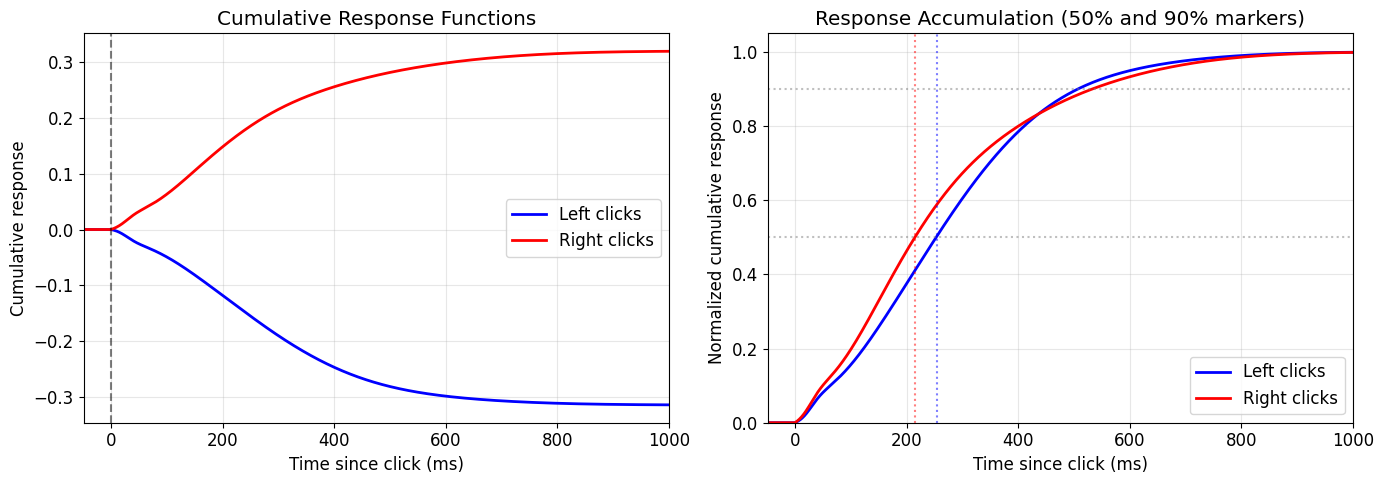

Response latencies (time to reach percentage of total response):
Left:  50% at 253.2ms, 90% at 507.4ms
Right: 50% at 215.2ms, 90% at 533.4ms


In [1101]:
# Calculate cumulative response functions
dt = t[1] - t[0]  # Time step
left_cumulative = np.cumsum(left_response) * dt
right_cumulative = np.cumsum(right_response) * dt

# Normalize to [0, 1] for percentage analysis
left_cumulative_norm = left_cumulative / (left_cumulative[-1] if left_cumulative[-1] != 0 else 1)
right_cumulative_norm = right_cumulative / (right_cumulative[-1] if right_cumulative[-1] != 0 else 1)

# Find key time points
left_50_idx = np.searchsorted(left_cumulative_norm, 0.5)
left_90_idx = np.searchsorted(left_cumulative_norm, 0.9)
right_50_idx = np.searchsorted(right_cumulative_norm, 0.5)
right_90_idx = np.searchsorted(right_cumulative_norm, 0.9)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute cumulative response
ax1.plot(t*1000, left_cumulative, 'b-', linewidth=2, label='Left clicks')
ax1.plot(t*1000, right_cumulative, 'r-', linewidth=2, label='Right clicks')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_xlabel('Time since click (ms)')
ax1.set_ylabel('Cumulative response')
ax1.set_title('Cumulative Response Functions')
ax1.set_xlim(-50, 1000)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Normalized cumulative response with markers
ax2.plot(t*1000, left_cumulative_norm, 'b-', linewidth=2, label='Left clicks')
ax2.plot(t*1000, right_cumulative_norm, 'r-', linewidth=2, label='Right clicks')
ax2.axvline(t[left_50_idx]*1000, color='blue', linestyle=':', alpha=0.5)
ax2.axvline(t[right_50_idx]*1000, color='red', linestyle=':', alpha=0.5)
ax2.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax2.axhline(0.9, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Time since click (ms)')
ax2.set_ylabel('Normalized cumulative response')
ax2.set_title('Response Accumulation (50% and 90% markers)')
ax2.set_xlim(-50, 1000)
ax2.set_ylim(0, 1.05)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Response latencies (time to reach percentage of total response):")
print(f"Left:  50% at {t[left_50_idx]*1000:.1f}ms, 90% at {t[left_90_idx]*1000:.1f}ms")
print(f"Right: 50% at {t[right_50_idx]*1000:.1f}ms, 90% at {t[right_90_idx]*1000:.1f}ms")

### 7.3 Response Function Characteristics

In [1102]:
# Calculate key metrics
left_peak_idx = left_response.argmax()
right_peak_idx = right_response.argmax()

left_peak_time = t[left_peak_idx] * 1000
right_peak_time = t[right_peak_idx] * 1000
left_peak_mag = left_response[left_peak_idx]
right_peak_mag = right_response[right_peak_idx]

# Find response duration (time to decay to 10% of peak)
left_10pct = 0.1 * left_peak_mag
right_10pct = 0.1 * right_peak_mag

left_duration_idx = np.where(left_response[left_peak_idx:] < left_10pct)[0]
right_duration_idx = np.where(right_response[right_peak_idx:] < right_10pct)[0]

left_duration = t[left_peak_idx + left_duration_idx[0]]*1000 if len(left_duration_idx) > 0 else 1500
right_duration = t[right_peak_idx + right_duration_idx[0]]*1000 if len(right_duration_idx) > 0 else 1500

# Total integrated response
left_total = np.trapz(left_response[t >= 0], t[t >= 0])
right_total = np.trapz(right_response[t >= 0], t[t >= 0])

# Asymmetry index
asymmetry = (left_total - right_total) / (left_total + right_total) if (left_total + right_total) > 0 else 0

# Create summary table
metrics_data = {
    'Metric': ['Peak Time (ms)', 'Peak Magnitude', 'Duration to 10% (ms)', 
               'Total Response (area)', '50% Latency (ms)', '90% Latency (ms)'],
    'Left Clicks': [f'{left_peak_time:.1f}', f'{left_peak_mag:.4f}', f'{left_duration:.1f}',
                    f'{left_total:.4f}', f'{t[left_50_idx]*1000:.1f}', f'{t[left_90_idx]*1000:.1f}'],
    'Right Clicks': [f'{right_peak_time:.1f}', f'{right_peak_mag:.4f}', f'{right_duration:.1f}',
                     f'{right_total:.4f}', f'{t[right_50_idx]*1000:.1f}', f'{t[right_90_idx]*1000:.1f}']
}

metrics_df = pd.DataFrame(metrics_data)
print("Response Function Characteristics:")
print(metrics_df.to_string(index=False))
print(f"\nAsymmetry Index (L-R)/(L+R): {asymmetry:.3f}")
print("Positive = left-biased, Negative = right-biased")

Response Function Characteristics:
               Metric Left Clicks Right Clicks
       Peak Time (ms)       -50.0        151.1
       Peak Magnitude      0.0000       0.8823
 Duration to 10% (ms)         0.0        687.5
Total Response (area)     -0.3142       0.3194
     50% Latency (ms)       253.2        215.2
     90% Latency (ms)       507.4        533.4

Asymmetry Index (L-R)/(L+R): -119.883
Positive = left-biased, Negative = right-biased


### 7.4 Comparison with Raw Basis Functions

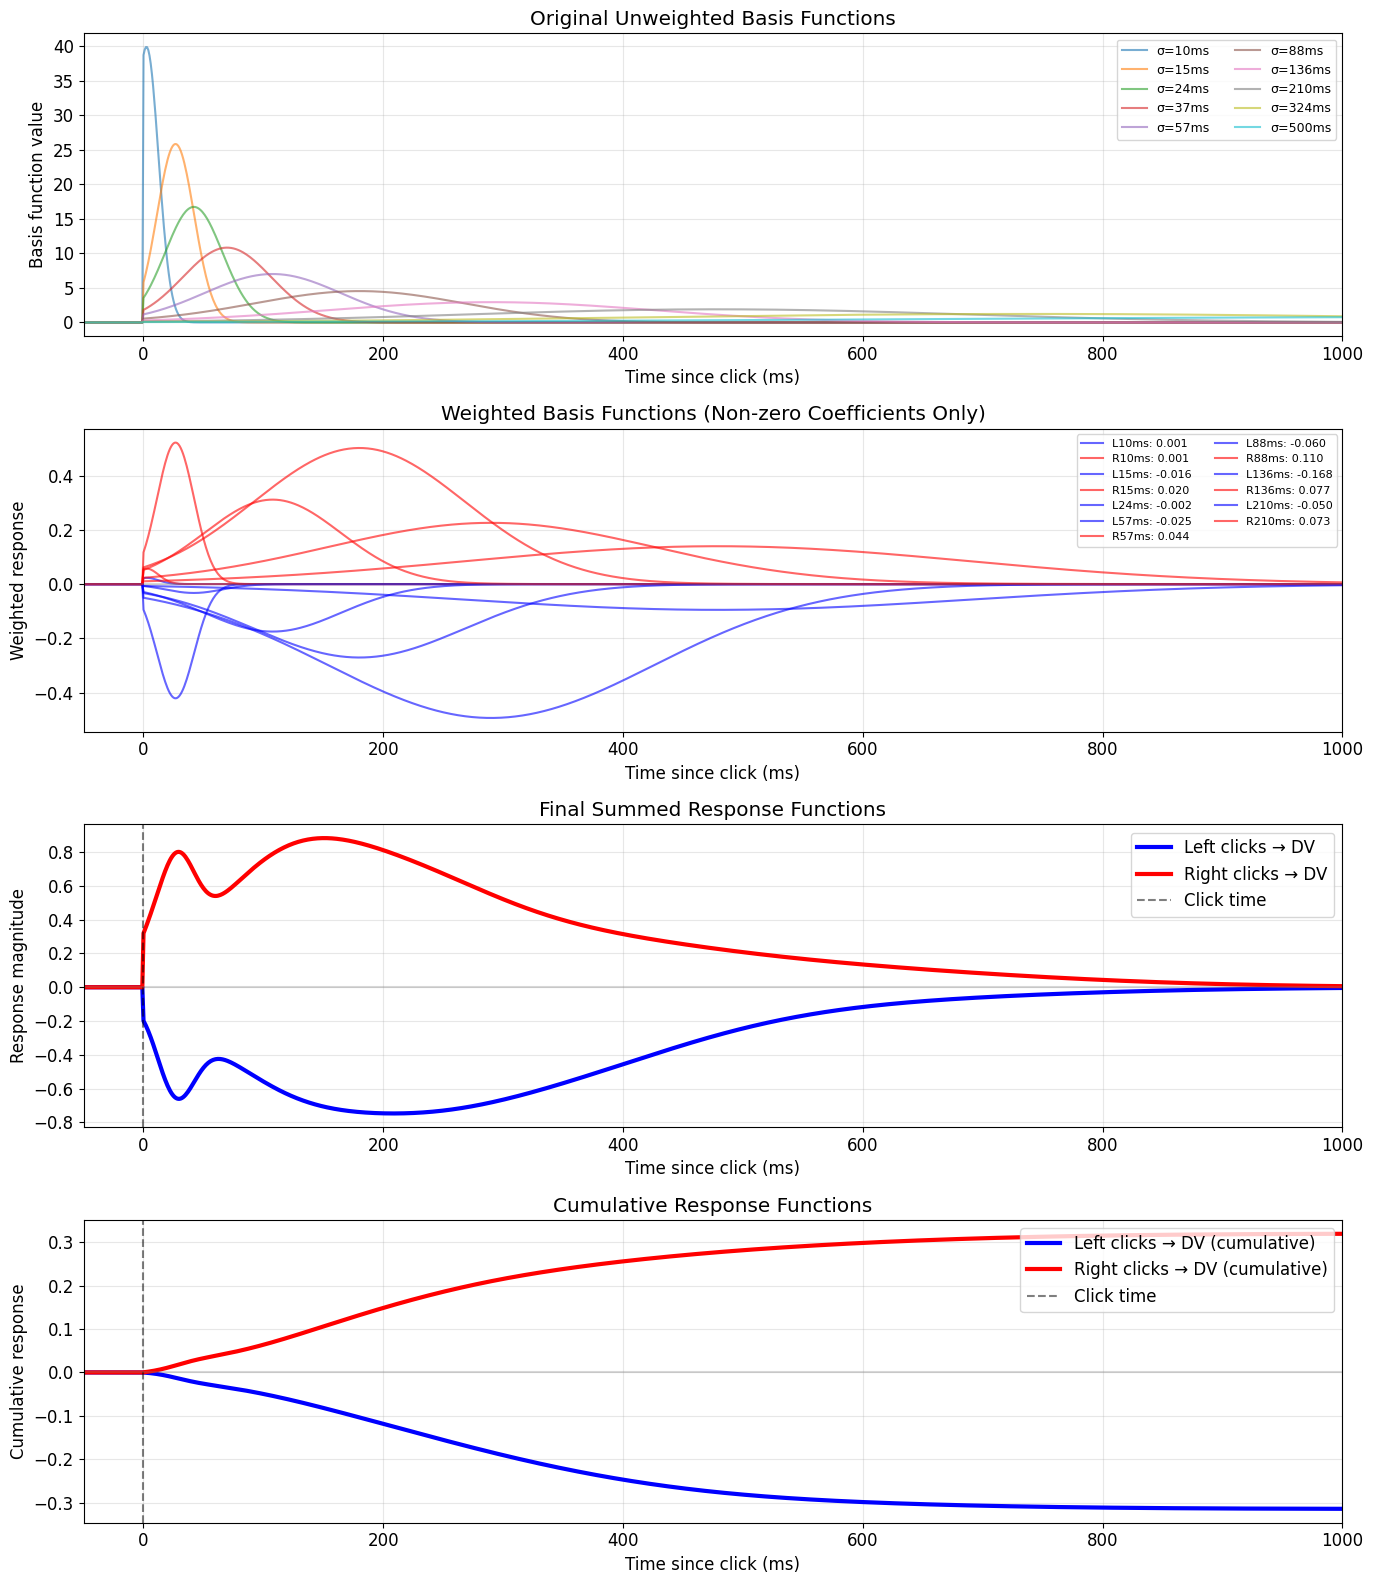

Regularization selected 13/20 features
This sparse selection shapes the temporal filter to focus on key timescales


In [1103]:
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Top: Original unweighted basis functions
ax = axes[0]
for i in range(n_basis):
    basis = gaussian_basis(t, centers[i], widths[i], causal=True)
    ax.plot(t*1000, basis, alpha=0.6, linewidth=1.5, 
            label=f'σ={widths[i]*1000:.0f}ms')
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Basis function value')
ax.set_title('Original Unweighted Basis Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right', ncol=2, fontsize=9)
ax.grid(True, alpha=0.3)

# Middle: Weighted basis functions
ax = axes[1]
for i in range(n_basis):
    if left_coefs[i] != 0:
        weighted = left_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax.plot(t*1000, weighted, 'b-', alpha=0.6, linewidth=1.5,
                label=f'L{widths[i]*1000:.0f}ms: {left_coefs[i]:.3f}')
    if right_coefs[i] != 0:
        weighted = right_coefs[i] * gaussian_basis(t, centers[i], widths[i], causal=True)
        ax.plot(t*1000, weighted, 'r-', alpha=0.6, linewidth=1.5,
                label=f'R{widths[i]*1000:.0f}ms: {right_coefs[i]:.3f}')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Weighted response')
ax.set_title('Weighted Basis Functions (Non-zero Coefficients Only)')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right', ncol=2, fontsize=8)
ax.grid(True, alpha=0.3)

# Third: Final summed response functions
ax = axes[2]
ax.plot(t*1000, left_response, 'b-', linewidth=3, label='Left clicks → DV')
ax.plot(t*1000, right_response, 'r-', linewidth=3, label='Right clicks → DV')
# ax.fill_between(t*1000, 0, left_response, where=(left_response > 0), 
#                  alpha=0.3, color='blue')
# ax.fill_between(t*1000, 0, right_response, where=(right_response > 0), 
#                  alpha=0.3, color='red')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Response magnitude')
ax.set_title('Final Summed Response Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Bottom: Cumulative Response Functions
ax = axes[3]
# Calculate cumulative responses
dt = t[1] - t[0]
left_cumulative = np.cumsum(left_response) * dt
right_cumulative = np.cumsum(right_response) * dt

ax.plot(t*1000, left_cumulative, 'b-', linewidth=3, label='Left clicks → DV (cumulative)')
ax.plot(t*1000, right_cumulative, 'r-', linewidth=3, label='Right clicks → DV (cumulative)')
# ax.fill_between(t*1000, 0, left_cumulative, where=(left_cumulative > 0), 
#                  alpha=0.3, color='blue')
# ax.fill_between(t*1000, 0, right_cumulative, where=(right_cumulative > 0), 
#                  alpha=0.3, color='red')
ax.axvline(0, color='black', linestyle='--', alpha=0.5, label='Click time')
ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
ax.set_xlabel('Time since click (ms)')
ax.set_ylabel('Cumulative response')
ax.set_title('Cumulative Response Functions')
ax.set_xlim(-50, 1000)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Regularization selected {n_features_selected}/{2*n_basis} features")
print(f"This sparse selection shapes the temporal filter to focus on key timescales")

## 8. Striations


## 8. Striation Analysis

Investigating the discrete patterns in model predictions.

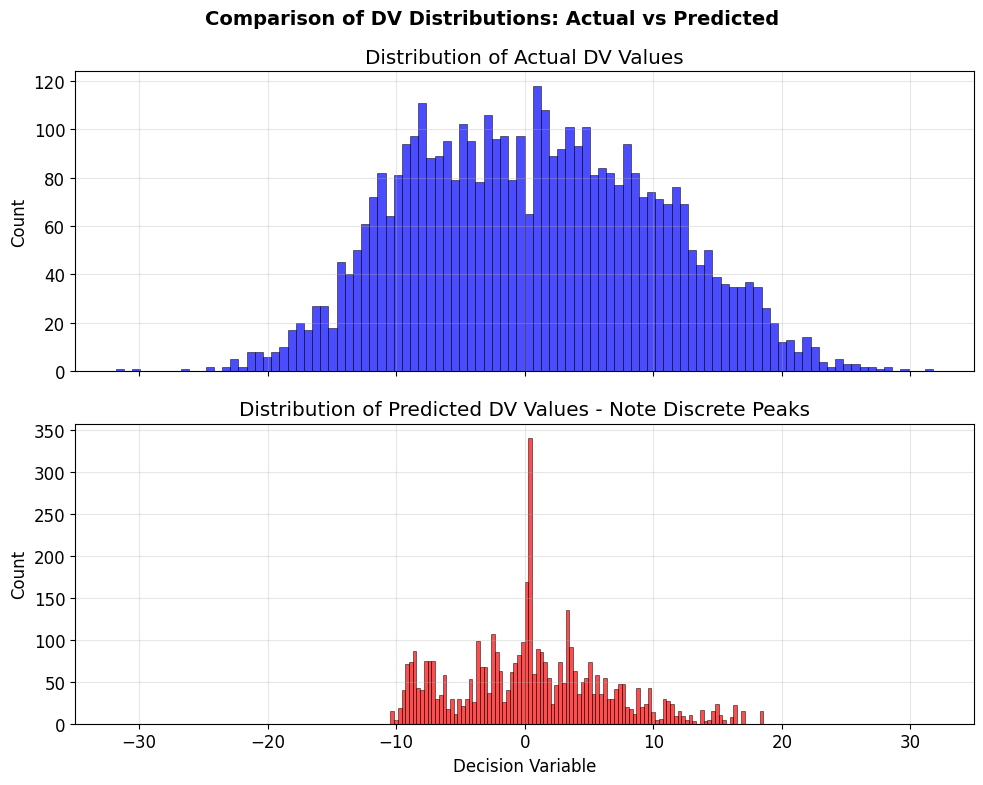

Actual DV - Unique values: 4266
Predicted DV - Unique values: 4266
Reduction in unique values: 0


In [1104]:
# Compare distributions of actual vs predicted DV values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Actual DV distribution
ax1.hist(y_all, bins=100, alpha=0.7, color='blue', edgecolor='black', linewidth=0.5)
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Actual DV Values')
ax1.grid(True, alpha=0.3)

# Predicted DV distribution  
ax2.hist(y_pred_all, bins=100, alpha=0.7, color='red', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Decision Variable')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Predicted DV Values - Note Discrete Peaks')
ax2.grid(True, alpha=0.3)

plt.suptitle('Comparison of DV Distributions: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print(f"Actual DV - Unique values: {len(np.unique(y_all))}")
print(f"Predicted DV - Unique values: {len(np.unique(y_pred_all))}")
print(f"Reduction in unique values: {len(np.unique(y_all)) - len(np.unique(y_pred_all))}")

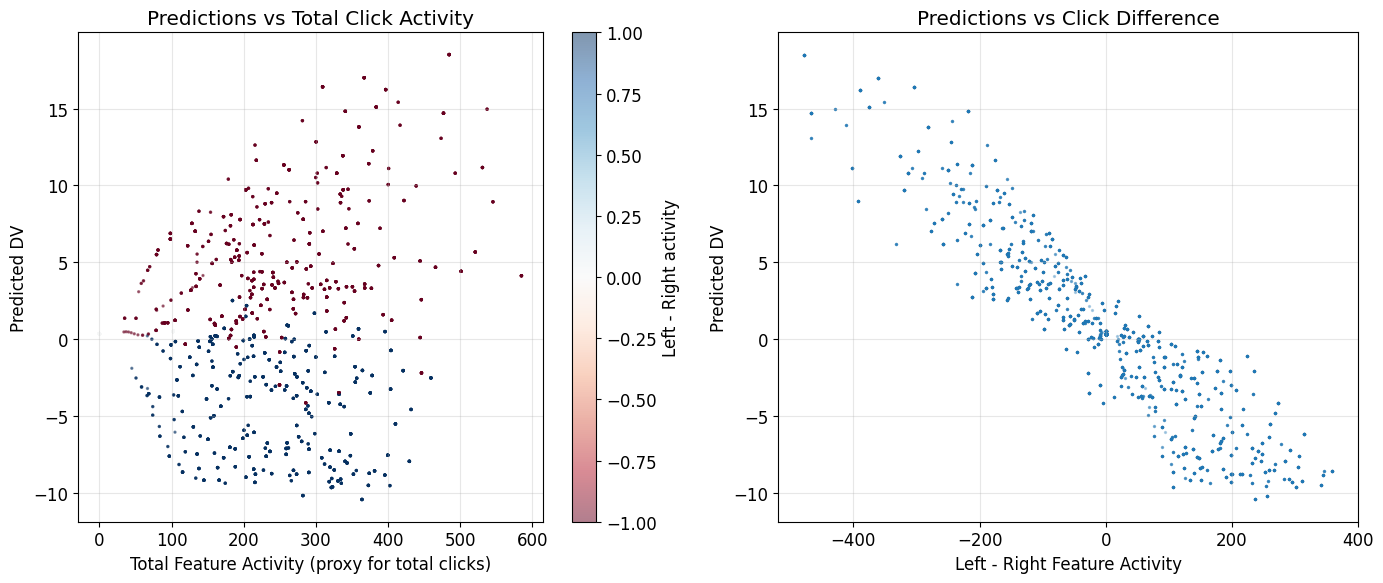

Unique total click values: 435
Unique click difference values: 434
This discretization in inputs contributes to striations in outputs


In [1105]:
# Calculate total clicks per data point
left_click_sums = X_valid[:, :n_basis].sum(axis=1)  # Sum of left features
right_click_sums = X_valid[:, n_basis:].sum(axis=1)  # Sum of right features
total_clicks = left_click_sums + right_click_sums
click_diff = left_click_sums - right_click_sums

# Get predictions for valid data
y_pred_valid = model.predict(X_valid)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left panel: Predictions vs total clicks
scatter1 = ax1.scatter(total_clicks, y_pred_valid, c=click_diff, cmap='RdBu', 
                       alpha=0.5, s=2, vmin=-1, vmax=1)
ax1.set_xlabel('Total Feature Activity (proxy for total clicks)')
ax1.set_ylabel('Predicted DV')
ax1.set_title('Predictions vs Total Click Activity')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Left - Right activity')

# Right panel: Predictions vs click difference
ax2.scatter(click_diff, y_pred_valid, alpha=0.3, s=2)
ax2.set_xlabel('Left - Right Feature Activity')
ax2.set_ylabel('Predicted DV')
ax2.set_title('Predictions vs Click Difference')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for discrete patterns
unique_totals = len(np.unique(np.round(total_clicks, 3)))
unique_diffs = len(np.unique(np.round(click_diff, 3)))
print(f"Unique total click values: {unique_totals}")
print(f"Unique click difference values: {unique_diffs}")
print(f"This discretization in inputs contributes to striations in outputs")

Text(0.5, 1.0, 'Distribution of actual DV - are there natural clusters?')

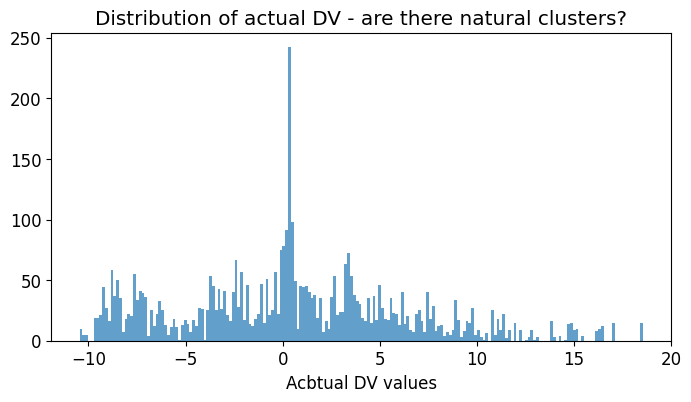

In [1106]:
plt.figure(figsize=(8, 4))
plt.hist(y_pred_all, bins=200, alpha=0.7)
plt.xlabel('Acbtual DV values')
plt.title('Distribution of actual DV - are there natural clusters?')

Text(0.5, 1.0, 'Distribution of actual DV - are there natural clusters?')

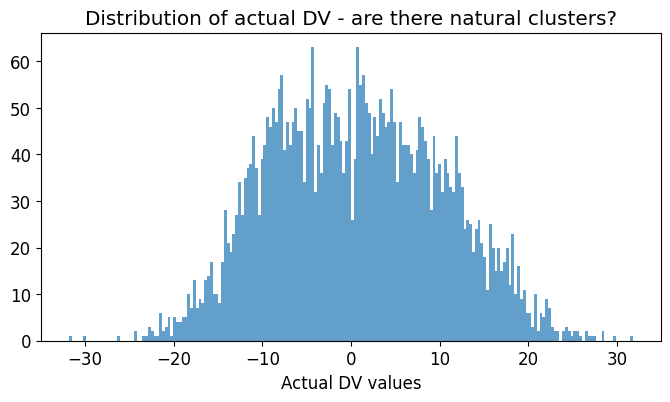

In [1107]:
plt.figure(figsize=(8, 4))
plt.hist(y_valid, bins=200, alpha=0.7)
plt.xlabel('Actual DV values')
plt.title('Distribution of actual DV - are there natural clusters?')

ValueError: x and y must be the same size

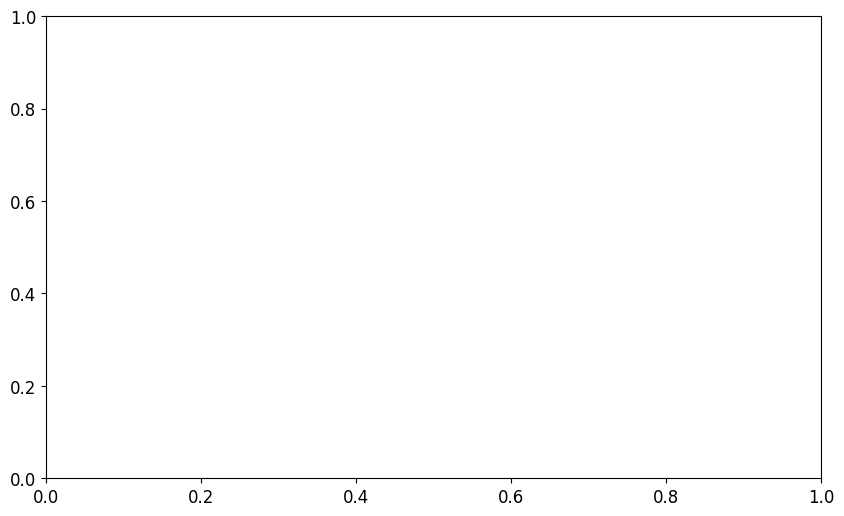

In [1108]:

# Calculate total clicks per trial
left_counts = []
right_counts = []
for trial_id in np.unique(trial_ids_valid):
    trial_clicks = click_df_240[click_df_240['trial_id'] == trial_id]
    left_counts.append(sum(trial_clicks['click_side'] == 'left'))
    right_counts.append(sum(trial_clicks['click_side'] == 'right'))

# Plot predictions colored by click difference
click_diff = np.array(left_counts) - np.array(right_counts)
plt.scatter(y_valid, y_pred_test, c=click_diff, cmap='RdBu', alpha=0.5)
plt.colorbar(label='Left - Right clicks')

In [ ]:
# Build improved feature matrix with smooth clicks
print("Building improved feature matrix with 3ms cosine clicks at 1ms resolution...")

X_smooth = []
y_smooth = []
valid_mask_smooth = []
trial_ids_smooth = []
time_bins_smooth = []

from tqdm import tqdm

# Process first 240 trials with smooth approach
n_trials_to_process = min(240, dv_df_240['trial_id'].max() + 1)

for trial_id in tqdm(range(n_trials_to_process), desc="Processing trials (smooth)"):
    # Get clicks for this trial
    trial_clicks = click_df_240[click_df_240['trial_id'] == trial_id]
    left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
    right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values
    
    # Get DVs for this trial
    trial_dvs = dv_df_240[dv_df_240['trial_id'] == trial_id]
    
    if len(trial_dvs) > 0:
        dv_eval_times = trial_dvs['time_bin'].values
        trial_duration = trial_dvs['time_bin'].max() + 0.05
        
        try:
            # Use improved feature creation with smooth clicks
            features_matrix = create_trial_features_smooth(
                left_clicks, right_clicks, dv_eval_times, centers, widths, trial_duration, dt=0.001
            )
            
            # Add features and targets
            for i, (_, dv_row) in enumerate(trial_dvs.iterrows()):
                X_smooth.append(features_matrix[i])
                y_smooth.append(dv_row['decision_variable'])
                valid_mask_smooth.append(dv_row['is_valid'])
                trial_ids_smooth.append(trial_id)
                time_bins_smooth.append(dv_row['time_bin'])
                
        except Exception as e:
            print(f"Warning: Error processing trial {trial_id}: {e}")
            continue

# Convert to arrays
X_smooth = np.array(X_smooth)
y_smooth = np.array(y_smooth)
valid_mask_smooth = np.array(valid_mask_smooth)
trial_ids_smooth = np.array(trial_ids_smooth)
time_bins_smooth = np.array(time_bins_smooth)

# Keep only valid points
X_smooth_valid = X_smooth[valid_mask_smooth]
y_smooth_valid = y_smooth[valid_mask_smooth]
trial_ids_smooth_valid = trial_ids_smooth[valid_mask_smooth]
time_bins_smooth_valid = time_bins_smooth[valid_mask_smooth]

print(f"\nImproved feature matrix constructed:")
print(f"X_smooth_valid shape: {X_smooth_valid.shape}")
print(f"y_smooth_valid shape: {y_smooth_valid.shape}")

# Compare with original
print(f"\nComparison with original approach:")
print(f"Original feature range: [{X_valid.min():.4f}, {X_valid.max():.4f}]")
print(f"Smooth feature range: [{X_smooth_valid.min():.4f}, {X_smooth_valid.max():.4f}]")
print(f"Original feature std: {X_valid.std():.4f}")
print(f"Smooth feature std: {X_smooth_valid.std():.4f}")

### 9.1 Rebuild Feature Matrix with Smooth Clicks

In [ ]:
# Visualize the improvement in click representation
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Plot 1: Raw click signals (old vs new)
ax = axes[0, 0]
time_old_ms = convs_old['time_grid'] * 1000
ax.stem(left_clicks * 1000, np.ones_like(left_clicks), basefmt=' ', 
        linefmt='b-', markerfmt='bo', label='Left clicks (delta)')
ax.stem(right_clicks * 1000, -np.ones_like(right_clicks), basefmt=' ', 
        linefmt='r-', markerfmt='ro', label='Right clicks (delta)')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Click representation')
ax.set_title('Old: Delta Function Clicks (5ms bins)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, trial_duration * 1000])

ax = axes[0, 1]
time_new_ms = convs_new['time_grid'] * 1000
ax.plot(time_new_ms, convs_new['clicks_left'], 'b-', linewidth=1.5, label='Left clicks (cosine)')
ax.plot(time_new_ms, -convs_new['clicks_right'], 'r-', linewidth=1.5, label='Right clicks (cosine)')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Click representation')
ax.set_title('New: 3ms Cosine Clicks (1ms bins)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, trial_duration * 1000])

# Plot 2: Zoom in on individual clicks
zoom_start, zoom_end = 200, 350  # ms
ax = axes[1, 0]
ax.plot(time_old_ms, convs_old['clicks_left'], 'b-', linewidth=2, label='Left')
ax.plot(time_old_ms, convs_old['clicks_right'], 'r-', linewidth=2, label='Right')
ax.set_xlim([zoom_start, zoom_end])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signal')
ax.set_title(f'Old: Zoomed View ({zoom_start}-{zoom_end}ms)')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.plot(time_new_ms, convs_new['clicks_left'], 'b-', linewidth=2, label='Left')
ax.plot(time_new_ms, convs_new['clicks_right'], 'r-', linewidth=2, label='Right')
ax.set_xlim([zoom_start, zoom_end])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signal')
ax.set_title(f'New: Zoomed View ({zoom_start}-{zoom_end}ms)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Example convolution output (basis function 2)
basis_idx = 2
ax = axes[2, 0]
ax.plot(time_old_ms, convs_old['left'][basis_idx], 'b-', alpha=0.7, label='Left')
ax.plot(time_old_ms, convs_old['right'][basis_idx], 'r-', alpha=0.7, label='Right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Convolved signal')
ax.set_title(f'Old: Convolution with Basis {basis_idx} (σ={widths[basis_idx]*1000:.1f}ms)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, trial_duration * 1000])

ax = axes[2, 1]
ax.plot(time_new_ms, convs_new['left'][basis_idx], 'b-', alpha=0.7, label='Left')
ax.plot(time_new_ms, convs_new['right'][basis_idx], 'r-', alpha=0.7, label='Right')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Convolved signal')
ax.set_title(f'New: Convolution with Basis {basis_idx} (σ={widths[basis_idx]*1000:.1f}ms)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim([0, trial_duration * 1000])

plt.suptitle(f'Click Representation Improvement - Trial {test_trial}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Cosine-shaped clicks create smoother, more continuous features")

In [ ]:
def create_trial_features_smooth(trial_clicks_left, trial_clicks_right, dv_eval_times, 
                                 centers, widths, trial_duration, 
                                 dt=0.001, store_convolutions=False):
    """
    Create feature matrix with 3ms cosine-shaped clicks at 1ms resolution.
    
    This improved approach:
    1. Uses 1ms temporal resolution (dt=0.001) instead of 5ms
    2. Represents clicks as 3ms cosine envelopes matching actual acoustics
    3. Convolves smooth click signal with Gaussian basis functions
    4. Subsamples at DV evaluation times
    
    Args:
        trial_clicks_left: Array of left click times for this trial
        trial_clicks_right: Array of right click times for this trial  
        dv_eval_times: Array of DV evaluation times for this trial
        centers: Basis function centers (temporal offsets in seconds)
        widths: Basis function widths (standard deviations in seconds)
        trial_duration: Duration of trial in seconds
        dt: Time step in seconds (default 1ms = 0.001)
        store_convolutions: If True, return full convolution outputs for visualization
    
    Returns:
        features_matrix: (n_dv_times, n_features) array where n_features = 2*n_basis
    """
    # Create click kernel for 3ms cosine envelope
    click_kernel = create_click_kernel(dt)
    kernel_len = len(click_kernel)
    
    # Create temporal grid at 1ms resolution with padding
    max_kernel_extent = 6 * widths.max()
    padded_duration = trial_duration + max_kernel_extent
    time_grid = np.arange(0, padded_duration + dt, dt)
    n_bins = len(time_grid)
    
    # Initialize smooth click signals (not impulses)
    clicks_left = np.zeros(n_bins)
    clicks_right = np.zeros(n_bins)
    
    # Place cosine-shaped clicks (not delta functions)
    for click_time in trial_clicks_left:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            # Place the cosine envelope centered at click time
            for i, amplitude in enumerate(click_kernel):
                if 0 <= bin_idx + i < n_bins:
                    clicks_left[bin_idx + i] += amplitude
    
    for click_time in trial_clicks_right:
        if 0 <= click_time < trial_duration:
            bin_idx = int(np.floor(click_time / dt))
            # Place the cosine envelope centered at click time
            for i, amplitude in enumerate(click_kernel):
                if 0 <= bin_idx + i < n_bins:
                    clicks_right[bin_idx + i] += amplitude
    
    # Initialize output
    n_dv_times = len(dv_eval_times)
    n_basis = len(widths)
    features_matrix = np.zeros((n_dv_times, 2 * n_basis))
    
    if store_convolutions:
        actual_trial_bins = int(np.ceil(trial_duration / dt))
        stored_convolutions = {
            'left': [],
            'right': [],
            'time_grid': time_grid[:actual_trial_bins],
            'clicks_left': clicks_left[:actual_trial_bins],
            'clicks_right': clicks_right[:actual_trial_bins],
            'dt': dt
        }
    
    # Convolve smooth click signals with Gaussian basis functions
    for i, width in enumerate(widths):
        # Create causal Gaussian kernel
        max_lag = min(6 * widths[i], padded_duration)
        kernel_n_bins = int(np.ceil(max_lag / dt)) + 1
        time_lags = np.arange(0, kernel_n_bins * dt, dt)
        causal_kernel = gaussian_basis(time_lags, centers[i], widths[i], causal=True)
        
        # Convolve smooth clicks with kernel
        conv_left_full = np.convolve(clicks_left, causal_kernel, mode='full')
        conv_right_full = np.convolve(clicks_right, causal_kernel, mode='full')
        
        # Trim to match original grid size
        conv_left = conv_left_full[:n_bins]
        conv_right = conv_right_full[:n_bins]
        
        if store_convolutions:
            actual_trial_bins = len(stored_convolutions['time_grid'])
            stored_convolutions['left'].append(conv_left[:actual_trial_bins])
            stored_convolutions['right'].append(conv_right[:actual_trial_bins])
        
        # Subsample at DV evaluation times
        for j, eval_time in enumerate(dv_eval_times):
            eval_bin = int(np.floor(eval_time / dt))
            if 0 <= eval_bin < n_bins:
                features_matrix[j, i] = conv_left[eval_bin]
                features_matrix[j, i + n_basis] = conv_right[eval_bin]
    
    if store_convolutions:
        return features_matrix, stored_convolutions
    else:
        return features_matrix

# Test the improved implementation
test_trial = 5
trial_clicks = click_df_240[click_df_240['trial_id'] == test_trial]
left_clicks = trial_clicks[trial_clicks['click_side'] == 'left']['time_from_first_click'].values
right_clicks = trial_clicks[trial_clicks['click_side'] == 'right']['time_from_first_click'].values

trial_dvs = dv_df_240[dv_df_240['trial_id'] == test_trial]
if len(trial_dvs) > 0:
    trial_duration = trial_dvs['time_bin'].max() + 0.05
    dv_times = trial_dvs['time_bin'].values
    
    # Compare old (delta) vs new (cosine) approaches
    features_old, convs_old = create_trial_features(
        left_clicks, right_clicks, dv_times, centers, widths, trial_duration, store_convolutions=True
    )
    
    features_new, convs_new = create_trial_features_smooth(
        left_clicks, right_clicks, dv_times, centers, widths, trial_duration, 
        dt=0.001, store_convolutions=True
    )
    
    print(f"Test trial {test_trial} comparison:")
    print(f"Old approach (5ms, delta): Features range [{features_old.min():.4f}, {features_old.max():.4f}]")
    print(f"New approach (1ms, cosine): Features range [{features_new.min():.4f}, {features_new.max():.4f}]")
    print(f"Smoothness improvement: {features_new.std() / features_old.std():.3f}x smoother variation")

In [ ]:
def create_click_kernel(dt=0.001):
    """
    Create a kernel matching the actual click shape:
    3ms cosine envelope as used in the behavioral experiment.
    
    Args:
        dt: Time step in seconds (default 1ms = 0.001s)
    
    Returns:
        envelope: Normalized cosine envelope array
    """
    # 3ms total width matching actual click duration
    click_duration = 0.003  # 3ms
    n_samples = int(np.ceil(click_duration / dt))
    t = np.linspace(0, click_duration, n_samples)
    
    # Raised cosine (Hann window) - matches the cosine envelope used in experiment
    envelope = 0.5 * (1 - np.cos(2 * np.pi * t / click_duration))
    
    # Normalize to preserve total energy (sum = 1)
    envelope = envelope / envelope.sum()
    
    return envelope

# Visualize the click kernel
dt_new = 0.001  # 1ms resolution
click_kernel = create_click_kernel(dt_new)
t_kernel = np.arange(len(click_kernel)) * dt_new * 1000  # Convert to ms

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t_kernel, click_kernel, 'b-', linewidth=2)
plt.fill_between(t_kernel, 0, click_kernel, alpha=0.3)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (normalized)')
plt.title('3ms Cosine Click Envelope')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Compare with delta function representation
plt.stem([1.5], [1], basefmt=' ', linefmt='r-', markerfmt='ro', label='Delta function (old)')
plt.plot(t_kernel, click_kernel * 3, 'b-', linewidth=2, label='3ms cosine (new)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Click Representation Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Click kernel: {len(click_kernel)} samples at {dt_new*1000}ms resolution")
print(f"Total duration: {len(click_kernel)*dt_new*1000:.1f}ms")
print(f"Kernel sum (should be 1.0): {click_kernel.sum():.6f}")

## 9. Improved Click Representation with 3ms Cosine Envelope

To reduce striations, we'll model clicks as they actually were: 3ms cosine-enveloped tone bursts. This requires 1ms temporal resolution.